In [190]:
import scipy.io
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

In [2]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results

In [3]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -12
encoding_dim = 64
dt = 1e-6
dx = 3456*0.2e-3/12
data_augmentation = False

In [86]:
#mat_syst_f60 = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f60.mat'))
mat_syst_f80 = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145.mat'))
#mat_rand_f60 = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces_random_f60.mat'))
#mat_rand_f80 = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces_random_f80.mat'))

In [87]:
#X_syst_f60 = mat_syst_f60['concat_traces'].astype('float32')
X_syst_f80 = mat_syst_f80['concat_traces'].astype('float32')
#X_rand_f60 = mat_rand_f60['concat_traces'].astype('float32')
#X_rand_f80 = mat_rand_f80['concat_traces'].astype('float32')


In [88]:
#X_syst_f60.shape, 
X_syst_f80.shape#, X_rand_f60.shape, X_rand_f80.shape

(3341, 401, 145)

In [89]:
#X = np.concatenate((X_syst_f60, X_syst_f80, X_rand_f60, X_rand_f80))
#X = np.concatenate((X_syst_f60, X_syst_f80))
X = X_syst_f80

In [90]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (3341, 145, 401))

In [92]:
X = X[:,9::18,:]

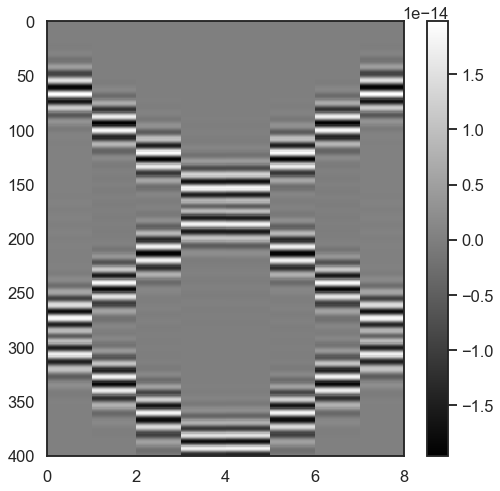

In [93]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [94]:
X.shape

(3341, 8, 401)

In [95]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

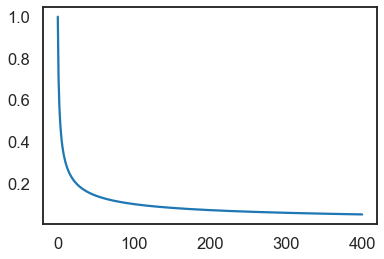

In [96]:
plt.plot(1/(time_scaling[0]))
plt.show()

In [14]:
#X = np.multiply(X, time_scaling)

In [97]:
X = np.divide(X, time_scaling)

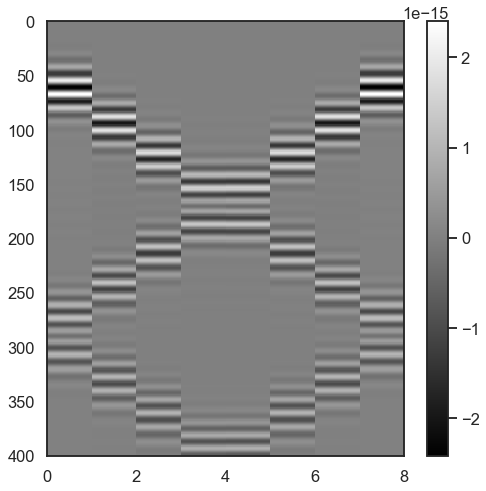

In [98]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [113]:
#labels_syst_f60 = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f60.csv'))
labels_syst_f80 = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f80_145.csv'))
#labels_rand_f60 = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_random_f60.csv'))
#labels_rand_f80 = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_random_f80.csv'))

In [114]:
#labels = pd.concat([labels_syst_f60, labels_syst_f80, labels_rand_f60, labels_rand_f80], ignore_index=True)
#labels = pd.concat([labels_syst_f60, labels_syst_f80], ignore_index=True)
labels = labels_syst_f80

In [115]:
len(labels)

3341

In [116]:
labels

modelname  thickness  seed  depression  pitting  \
0     model_s101_t032_d000_p000        6.4   101         0.0      0.0   
1     model_s101_t032_d000_p002        6.4   101         0.0      0.4   
2     model_s101_t032_d000_p004        6.4   101         0.0      0.8   
3     model_s101_t032_d000_p006        6.4   101         0.0      1.2   
4     model_s101_t032_d000_p008        6.4   101         0.0      1.6   
...                         ...        ...   ...         ...      ...   
3336  model_s116_t040_d024_p002        8.0   116         4.8      0.4   
3337  model_s116_t040_d024_p004        8.0   116         4.8      0.8   
3338  model_s116_t040_d024_p006        8.0   116         4.8      1.2   
3339  model_s116_t040_d024_p008        8.0   116         4.8      1.6   
3340  model_s116_t040_d024_p010        8.0   116         4.8      2.0   

      depression_mu  depression_sigma  thickness_max  thickness_min  \
0        351.267366         55.653407            6.4            6.4   
1        351.267366         55.653407            6.4            6.0   
2        351.267366         55.653407            6.4            5.6   
3        351.267366         55.653407            6.4            5.2   
4        351.267366         55.653407            6.4            4.8   
...             ...               ...            ...            ...   
3336     302.458280         37.896593            8.0            2.8   
3337     302.458280         37.896593            8.0            2.4   
3338     302.458280         37.896593            8.0            2.0   
3339     302.458280         37.896593            8.0            2.0   
3340     302.458280         37.896593            8.0            2.0   

      thickness_mean  thickness_median  thickness_std  thickness_var  \
0           6.400000               6.4       0.000000       0.000000   
1           6.209375               6.2       0.145174       0.021076   
2           6.087269               6.2       0.230522       0.053140   
3           6.027662               6.0       0.291548       0.085000   
4           6.005903               6.0       0.324993       0.105621   
...              ...               ...            ...            ...   
3336        7.147569               7.8       1.357483       1.842761   
3337        7.017766               7.6       1.367905       1.871163   
3338        6.960301               7.6       1.382729       1.911940   
3339        6.944213               7.6       1.387165       1.924227   
3340        6.937731               7.4       1.387106       1.924064   

      model_rough_coeff  num_pits  
0              1.000000         0  
1              1.269029         0  
2              1.307393       191  
3              1.317464        78  
4              1.319622        23  
...                 ...       ...  
3336           1.264473         0  
3337           1.309311       174  
3338           1.317943        75  
3339           1.319622        15  
3340           1.320341         5  

[3341 rows x 15 columns]

In [117]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [118]:
labels

modelname  Thickness  seed  Depression depth  \
0     model_s101_t032_d000_p000        6.4   101               0.0   
1     model_s101_t032_d000_p002        6.4   101               0.0   
2     model_s101_t032_d000_p004        6.4   101               0.0   
3     model_s101_t032_d000_p006        6.4   101               0.0   
4     model_s101_t032_d000_p008        6.4   101               0.0   
...                         ...        ...   ...               ...   
3336  model_s116_t040_d024_p002        8.0   116               4.8   
3337  model_s116_t040_d024_p004        8.0   116               4.8   
3338  model_s116_t040_d024_p006        8.0   116               4.8   
3339  model_s116_t040_d024_p008        8.0   116               4.8   
3340  model_s116_t040_d024_p010        8.0   116               4.8   

      Pitting depth  Depression location  Depression width  Thickness maximum  \
0               0.0           351.267366         55.653407                6.4   
1               0.4           351.267366         55.653407                6.4   
2               0.8           351.267366         55.653407                6.4   
3               1.2           351.267366         55.653407                6.4   
4               1.6           351.267366         55.653407                6.4   
...             ...                  ...               ...                ...   
3336            0.4           302.458280         37.896593                8.0   
3337            0.8           302.458280         37.896593                8.0   
3338            1.2           302.458280         37.896593                8.0   
3339            1.6           302.458280         37.896593                8.0   
3340            2.0           302.458280         37.896593                8.0   

      Thickness minimum  Thickness mean  Thickness median  Thickness std  \
0                   6.4        6.400000               6.4       0.000000   
1                   6.0        6.209375               6.2       0.145174   
2                   5.6        6.087269               6.2       0.230522   
3                   5.2        6.027662               6.0       0.291548   
4                   4.8        6.005903               6.0       0.324993   
...                 ...             ...               ...            ...   
3336                2.8        7.147569               7.8       1.357483   
3337                2.4        7.017766               7.6       1.367905   
3338                2.0        6.960301               7.6       1.382729   
3339                2.0        6.944213               7.6       1.387165   
3340                2.0        6.937731               7.4       1.387106   

      thickness_var  model_rough_coeff  num_pits  
0          0.000000           1.000000         0  
1          0.021076           1.269029         0  
2          0.053140           1.307393       191  
3          0.085000           1.317464        78  
4          0.105621           1.319622        23  
...             ...                ...       ...  
3336       1.842761           1.264473         0  
3337       1.871163           1.309311       174  
3338       1.911940           1.317943        75  
3339       1.924227           1.319622        15  
3340       1.924064           1.320341         5  

[3341 rows x 15 columns]

In [119]:
cases_ideal = labels[(labels['Depression depth'] == 0) & (labels['Pitting depth'] == 0)].index.tolist()

In [120]:
cases_ideal

[0,
 42,
 84,
 126,
 168,
 210,
 250,
 292,
 334,
 376,
 418,
 458,
 500,
 542,
 584,
 626,
 666,
 708,
 750,
 792,
 834,
 876,
 918,
 960,
 1002,
 1044,
 1085,
 1127,
 1169,
 1211,
 1253,
 1295,
 1337,
 1379,
 1421,
 1463,
 1503,
 1545,
 1587,
 1629,
 1671,
 1711,
 1753,
 1795,
 1837,
 1879,
 1919,
 1961,
 2003,
 2045,
 2087,
 2129,
 2171,
 2213,
 2255,
 2297,
 2337,
 2379,
 2421,
 2463,
 2505,
 2547,
 2589,
 2631,
 2673,
 2715,
 2755,
 2797,
 2839,
 2881,
 2923,
 2964,
 3005,
 3047,
 3089,
 3131,
 3173,
 3215,
 3257,
 3299]

In [121]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [122]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
#X_sample_n = make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

In [123]:
#label_sample = label_sample.sample(frac=1) # Remove in production!!

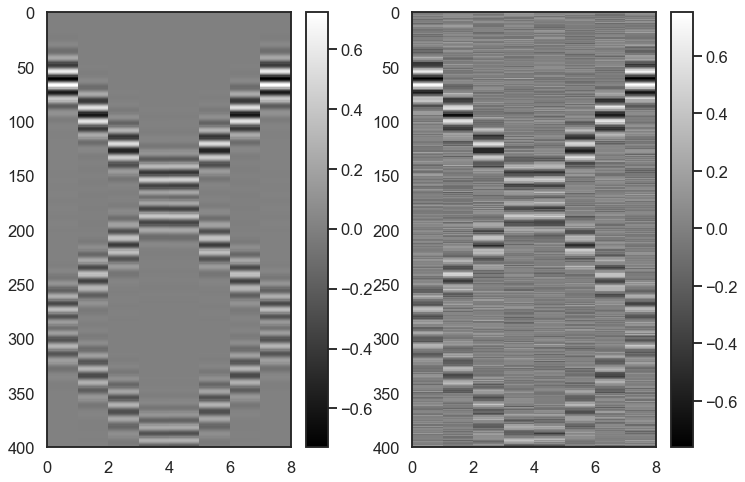

In [124]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [125]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [127]:
# If subselection of sensors are to be picked
#X_sample_n = pick_sensors(X_sample_n, sensorindex)
#X_sample_c = pick_sensors(X_sample_c, sensorindex)
#X_sample_n.shape, X_sample_c.shape

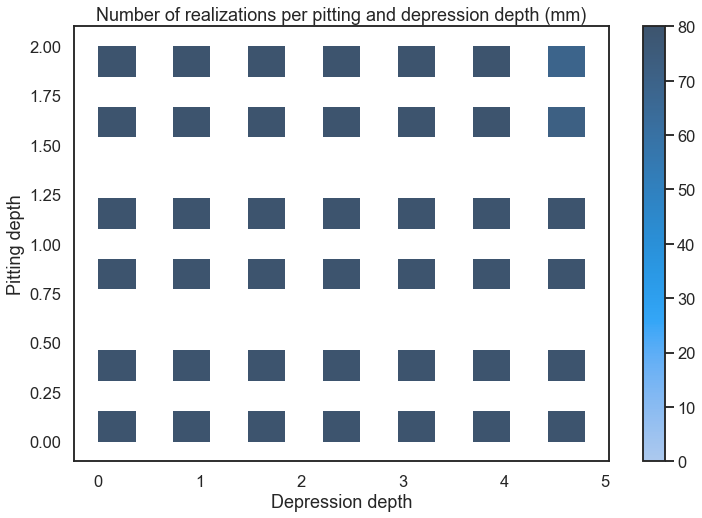

In [128]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

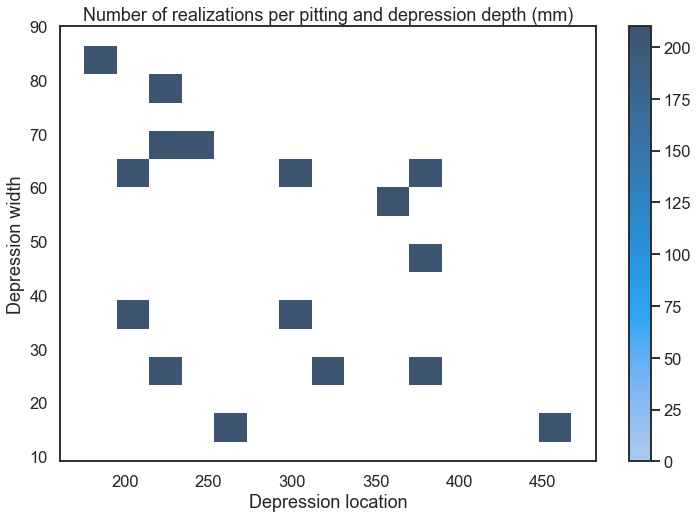

In [129]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression location", y="Depression width", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

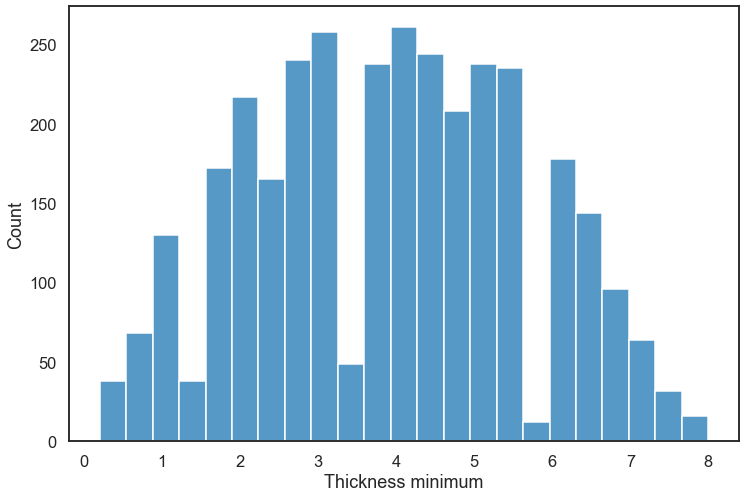

In [130]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

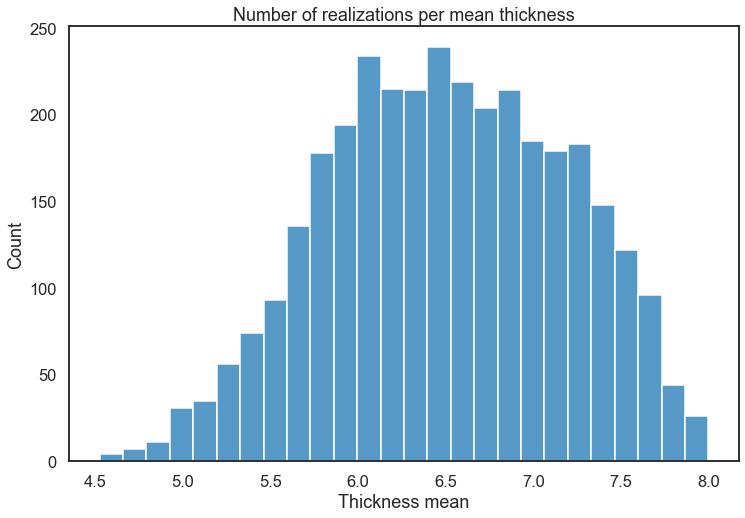

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

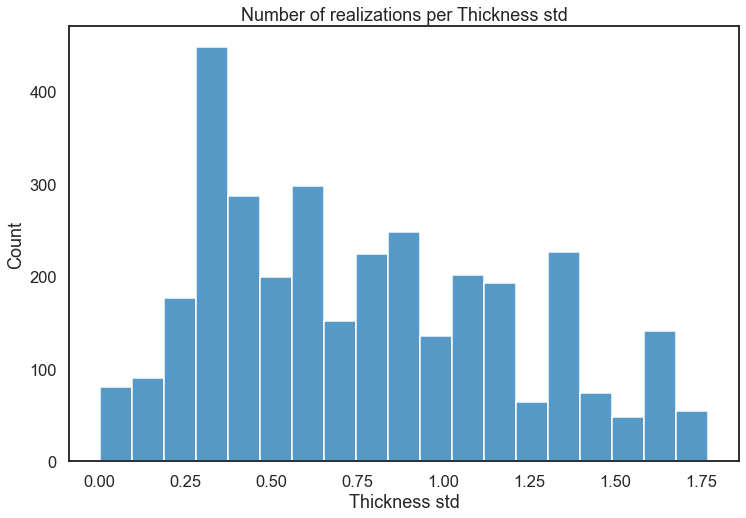

In [132]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness std")
plt.title("Number of realizations per Thickness std")
plt.show()

# Augmentation of idealized cases

In [133]:
labels[(labels['Thickness std'] <= 0.25)]

modelname  Thickness  seed  Depression depth  \
0     model_s101_t032_d000_p000        6.4   101               0.0   
1     model_s101_t032_d000_p002        6.4   101               0.0   
2     model_s101_t032_d000_p004        6.4   101               0.0   
42    model_s101_t034_d000_p000        6.8   101               0.0   
43    model_s101_t034_d000_p002        6.8   101               0.0   
...                         ...        ...   ...               ...   
3263  model_s116_t038_d004_p000        7.6   116               0.8   
3299  model_s116_t040_d000_p000        8.0   116               0.0   
3300  model_s116_t040_d000_p002        8.0   116               0.0   
3301  model_s116_t040_d000_p004        8.0   116               0.0   
3305  model_s116_t040_d004_p000        8.0   116               0.8   

      Pitting depth  Depression location  Depression width  Thickness maximum  \
0               0.0           351.267366         55.653407                6.4   
1               0.4           351.267366         55.653407                6.4   
2               0.8           351.267366         55.653407                6.4   
42              0.0           351.267366         55.653407                6.8   
43              0.4           351.267366         55.653407                6.8   
...             ...                  ...               ...                ...   
3263            0.0           302.458280         37.896593                7.6   
3299            0.0           302.458280         37.896593                8.0   
3300            0.4           302.458280         37.896593                8.0   
3301            0.8           302.458280         37.896593                8.0   
3305            0.0           302.458280         37.896593                8.0   

      Thickness minimum  Thickness mean  Thickness median  Thickness std  \
0                   6.4        6.400000               6.4       0.000000   
1                   6.0        6.209375               6.2       0.145174   
2                   5.6        6.087269               6.2       0.230522   
42                  6.8        6.800000               6.8       0.000000   
43                  6.4        6.603877               6.6       0.145226   
...                 ...             ...               ...            ...   
3263                6.8        7.491898               7.6       0.229977   
3299                8.0        8.000000               8.0       0.000000   
3300                7.6        7.808796               7.8       0.147269   
3301                7.2        7.681829               7.8       0.234640   
3305                7.2        7.891898               8.0       0.229977   

      thickness_var  model_rough_coeff  num_pits  
0          0.000000           1.000000         0  
1          0.021076           1.269029         0  
2          0.053140           1.307393       191  
42         0.000000           1.000000         0  
43         0.021091           1.271427         0  
...             ...                ...       ...  
3263       0.052889           1.000959         0  
3299       0.000000           1.000000         0  
3300       0.021688           1.266152         0  
3301       0.055056           1.305955       203  
3305       0.052889           1.000959         0  

[295 rows x 15 columns]

In [134]:
cases_low_std = labels[(labels['Thickness std'] < 0.25)].index.tolist()

# ML

In [135]:
#x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)
if data_augmentation:
  X_sample_low_std_c = np.squeeze(X_sample_c[cases_low_std, :, :, :])
  X_sample_low_std_4times_c = np.concatenate((X_sample_low_std_c, X_sample_low_std_c, X_sample_low_std_c, X_sample_low_std_c))
  np.random.shuffle(X_sample_low_std_4times_c)
  X_sample_low_std_4times_n = X_sample_low_std_4times_c + make_noise(noisedb, X_sample_low_std_4times_c.shape)

  X_sample_low_std_4times_c = np.expand_dims(X_sample_low_std_4times_c, 1)
  X_sample_low_std_4times_n = np.expand_dims(X_sample_low_std_4times_n, 1)

  X_sample_c_autoencode = np.concatenate((X_sample_c, X_sample_low_std_4times_c))
  X_sample_n_autoencode = np.concatenate((X_sample_n, X_sample_low_std_4times_n))
  x_train, x_test, y_train, y_test = train_test_split(X_sample_n_autoencode, X_sample_c_autoencode, test_size=0.2, random_state=42)
else:
  x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [136]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

Epoch 1/100
11/11 [==============================] - 3s 147ms/step - loss: 0.0160 - val_loss: 0.0098
Epoch 2/100
11/11 [==============================] - 1s 112ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 3/100
11/11 [==============================] - 2s 144ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 4/100
11/11 [==============================] - 2s 156ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/100
11/11 [==============================] - 2s 148ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/100
11/11 [==============================] - 2s 152ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/100
11/11 [==============================] - 2s 158ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/100
11/11 [==============================] - 2s 151ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/100
11/11 [==============================] - 2s 142ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/100
11/11 [==============================] - 1s 130ms/step - loss: 0.0014 - val_lo

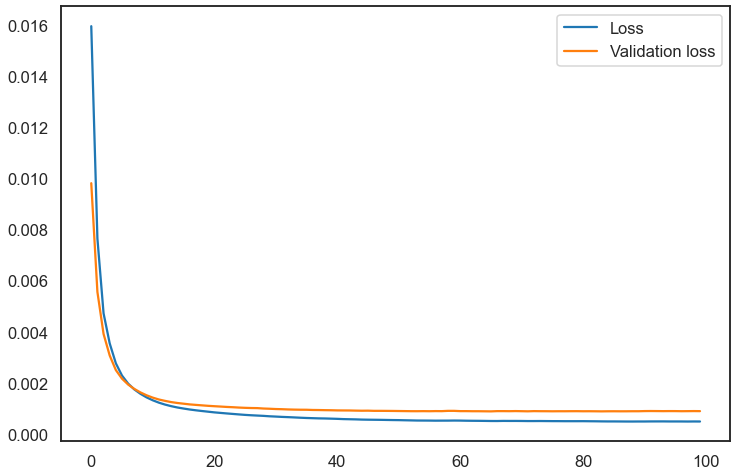

In [137]:
autoencoder_tx, encoder_tx = make_autoencoder(input_dim=x_train_flat.shape[1], encoding_dim=encoding_dim, activation='tanh')
autoencoder_tx.compile(optimizer='adam', loss='mse')

history = autoencoder_tx.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [138]:
autoencoder_tx.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3200)]            0         
                                                                 
 dense (Dense)               (None, 512)               1638912   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024 

In [139]:
decoded_traces = autoencoder_tx.predict(x_test_flat)
encoded_traces = encoder_tx.predict(x_test_flat)

21/21 [==============================] - 0s 7ms/step


In [140]:
encoded_traces.shape, decoded_traces.shape

((669, 64), (669, 3200))

In [141]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [142]:
x_test.shape, test_decoded_shaped.shape

((669, 1, 8, 400), (669, 1, 8, 400))

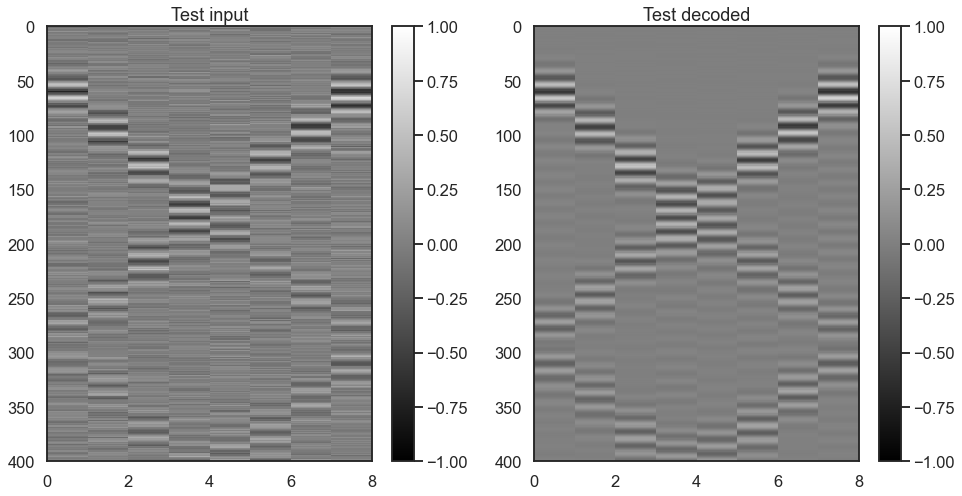

In [143]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

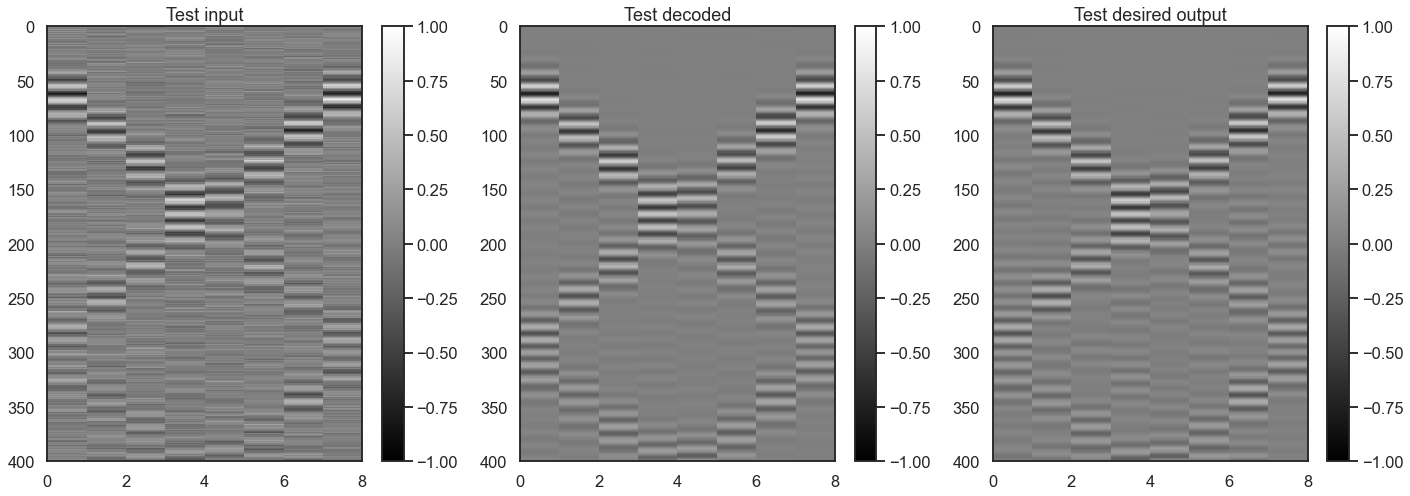

In [144]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [145]:
autoencoder_tx.evaluate(x_test_flat, x_test_flat)

 1/21 [>.............................] - ETA: 1s - loss: 0.0046

21/21 [==============================] - 0s 10ms/step - loss: 0.0047


0.004723725374788046

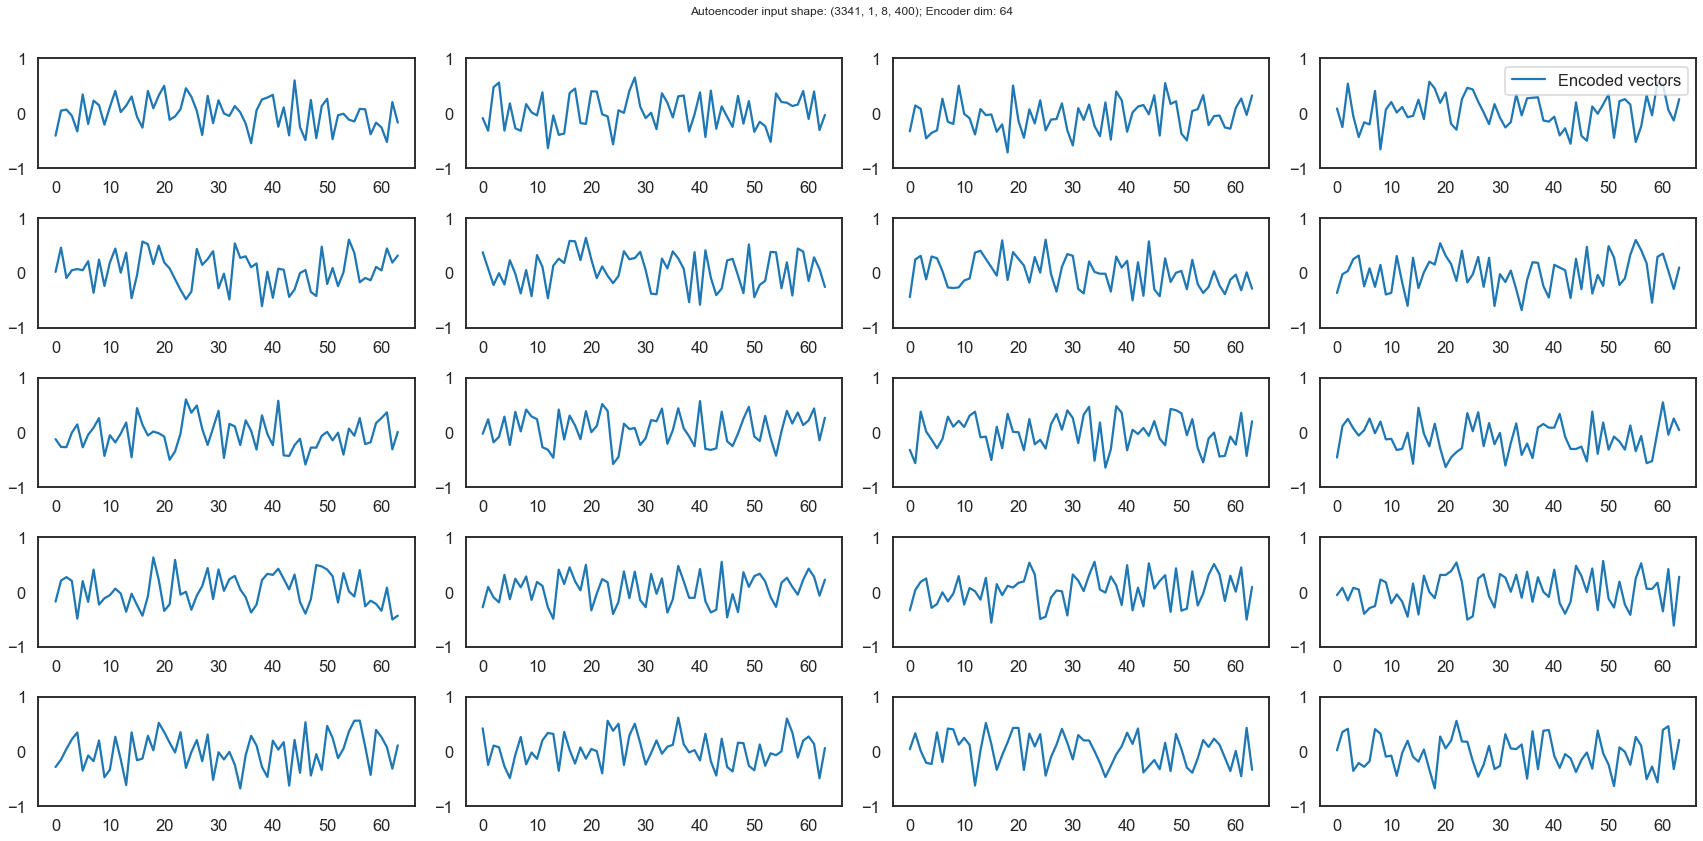

In [146]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [147]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(3341, 3200)

In [148]:
encoded_all = encoder_tx.predict(X_sample_flat)

  1/105 [..............................] - ETA: 5s

105/105 [==============================] - 1s 8ms/step


In [149]:
#attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression location','Pitting depth']
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

Thickness mean
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


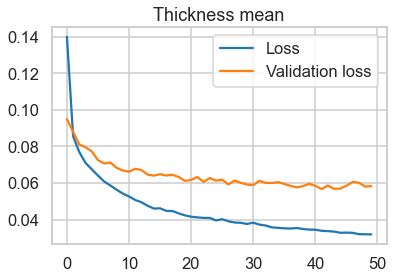

21/21 [==============================] - 0s 3ms/step - loss: 0.0583
loss: 0.05831978842616081
Thickness minimum
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


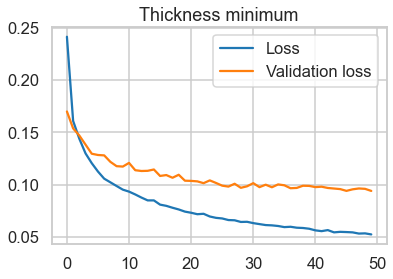

21/21 [==============================] - 0s 2ms/step - loss: 0.0941
loss: 0.09406030178070068
Thickness std
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


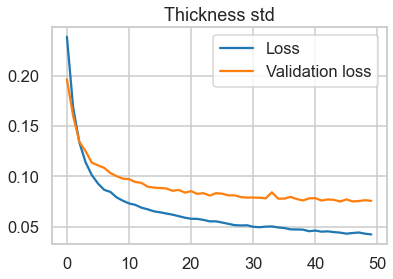

21/21 [==============================] - 0s 2ms/step - loss: 0.0758
loss: 0.07584037631750107
Depression depth
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


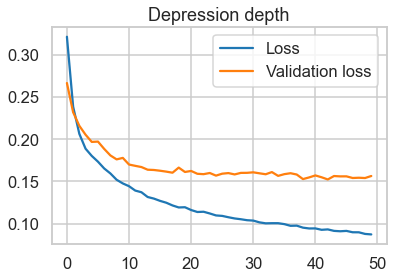

21/21 [==============================] - 0s 2ms/step - loss: 0.1564
loss: 0.15639257431030273
Depression width
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


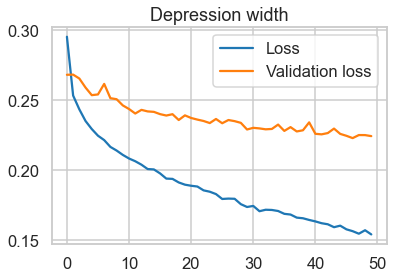

21/21 [==============================] - 0s 4ms/step - loss: 0.2245
loss: 0.22452640533447266
Pitting depth
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


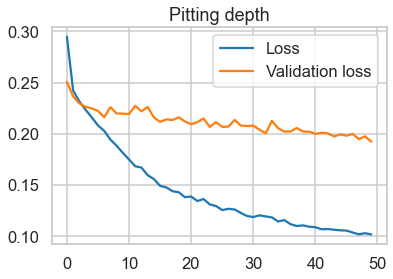

21/21 [==============================] - 0s 2ms/step - loss: 0.1924
loss: 0.19238822162151337


In [150]:
df_loss, df_test, df_predict, autoencoder_regression_models_tx, min_max_scalers = do_regression(encoded_all, label_sample, attributes)

In [151]:
autoencoder_regression_models_tx['Thickness mean'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________


In [152]:
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

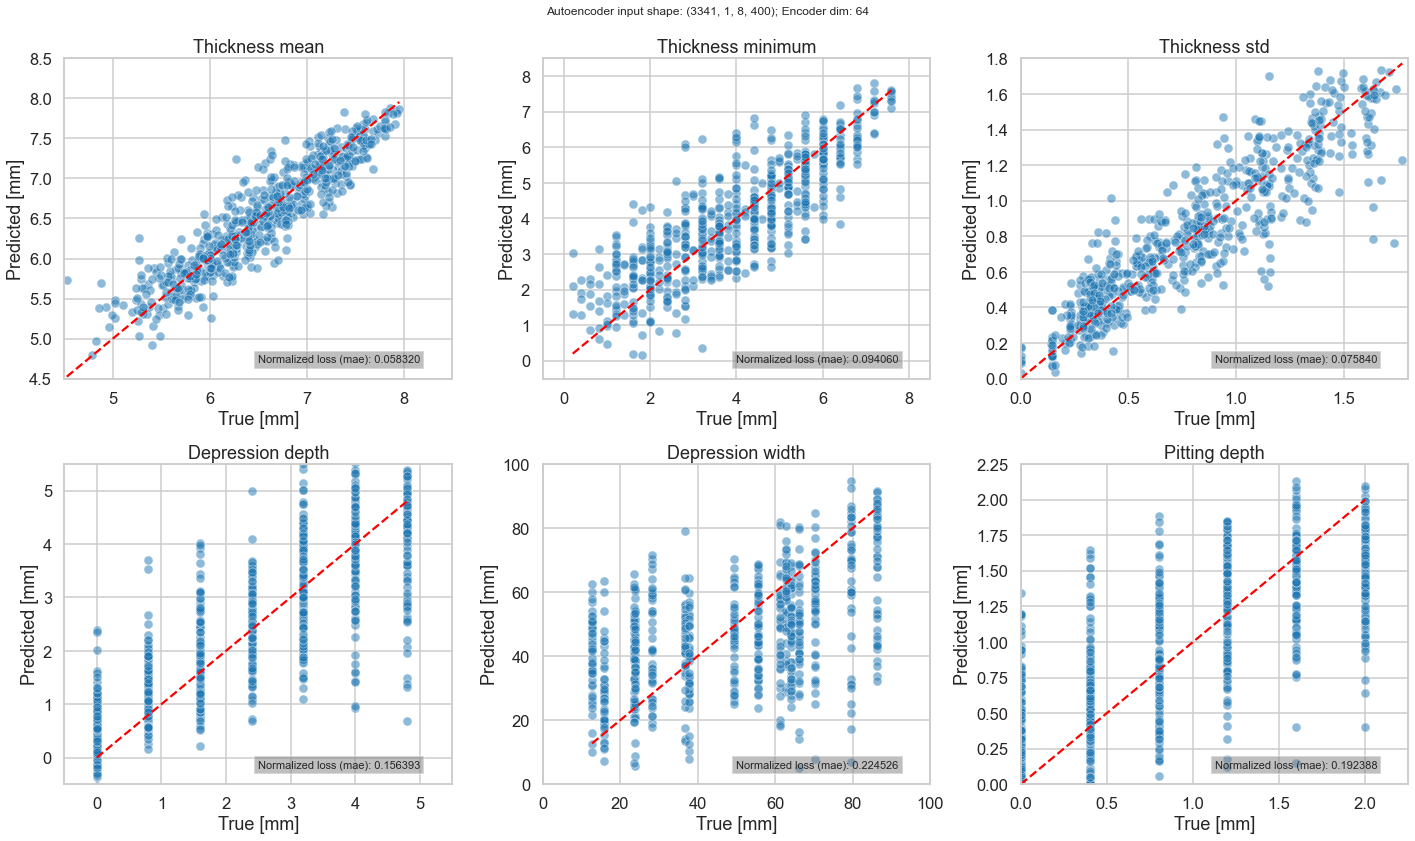

In [153]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim))

## Direct Regression

In [154]:
X_sample_n.shape

(3341, 1, 8, 400)

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


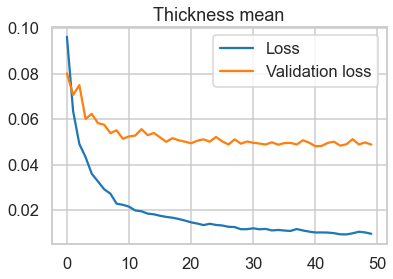

21/21 [==============================] - 0s 2ms/step - loss: 0.0488
loss: 0.0488082580268383
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


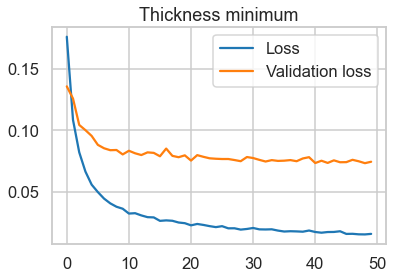

21/21 [==============================] - 0s 2ms/step - loss: 0.0746
loss: 0.07457124441862106
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


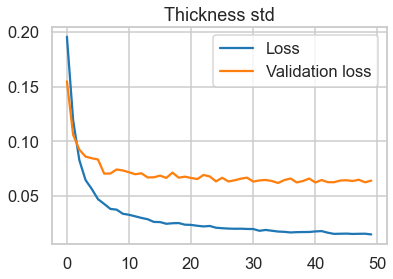

21/21 [==============================] - 0s 2ms/step - loss: 0.0641
loss: 0.06409406661987305
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


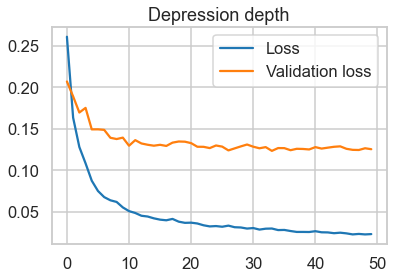

21/21 [==============================] - 0s 2ms/step - loss: 0.1255
loss: 0.12554201483726501
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


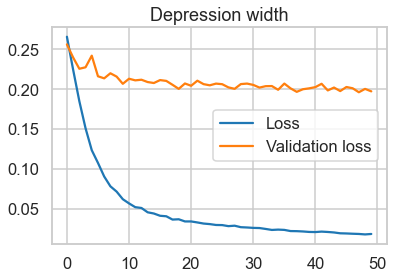

21/21 [==============================] - 0s 3ms/step - loss: 0.1973
loss: 0.19731466472148895
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


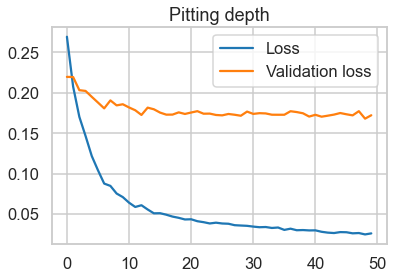

21/21 [==============================] - 0s 7ms/step - loss: 0.1723
loss: 0.17225715517997742


In [155]:
df_loss, df_test, df_predict, direct_regression_models_tx, min_max_scalers = do_regression(X_sample_n, label_sample, attributes)

In [156]:
direct_regression_models_tx['Thickness mean'].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                204864    
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 16)                528       
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                                 
 dense_42 (Dense)            (None, 4)                 36        
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
Total params: 207,649
Trainable params: 207,649
Non-tr

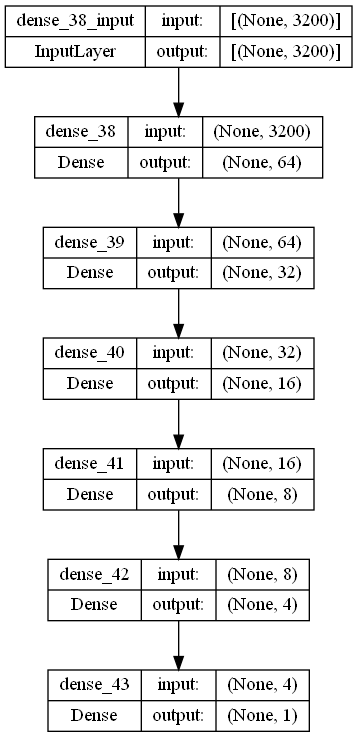

In [157]:
plot_model(direct_regression_models_tx['Thickness mean'], show_shapes=True, show_layer_names=True)

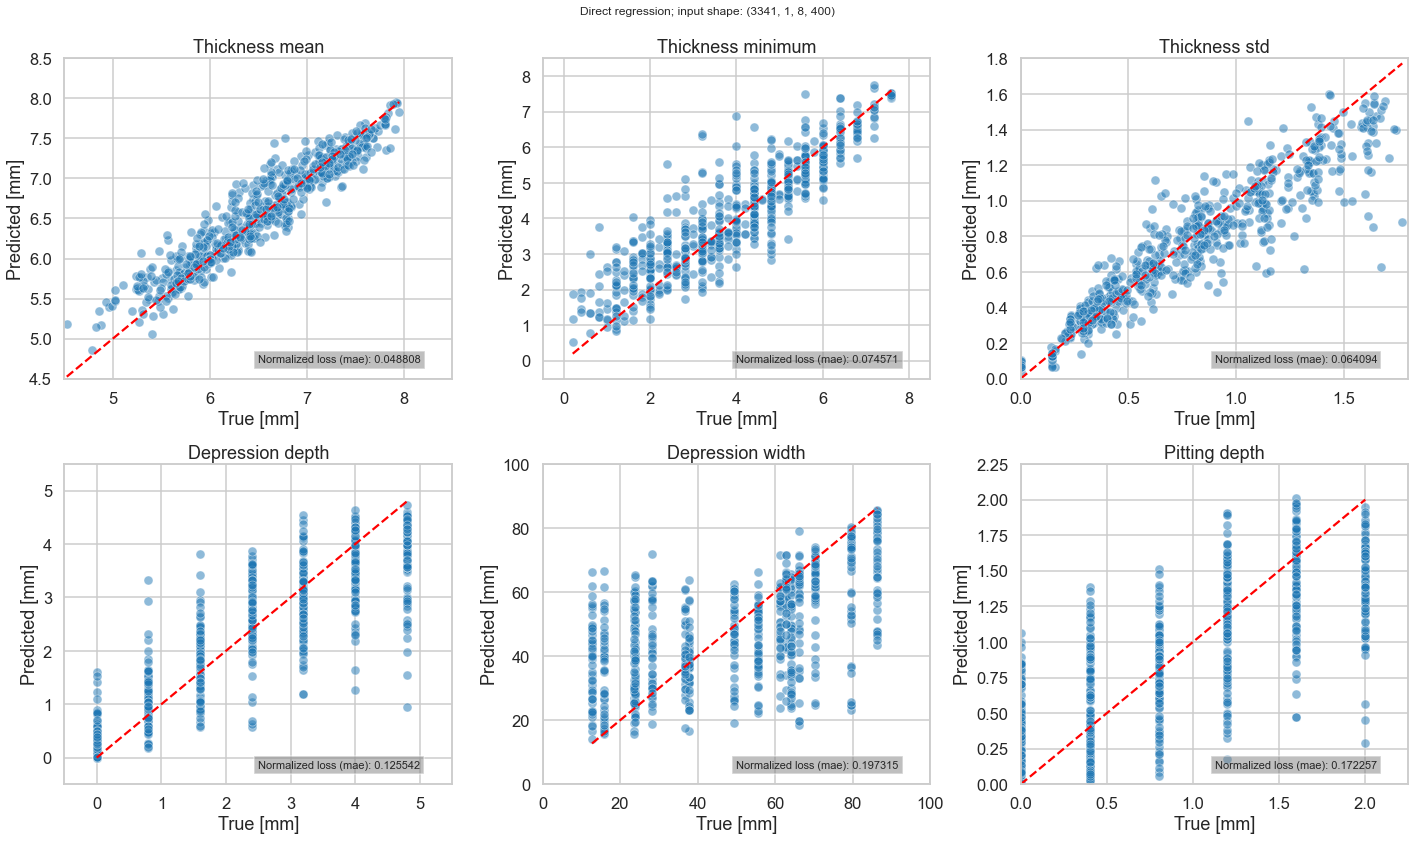

In [158]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Real data

## Verasonics data

In [159]:
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_09', 'data')
pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_14', 'data')

In [160]:
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-03_15_15_55.mat')
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-09_15_57_15.mat')

#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_22_20.mat') #strap off
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_26_56.mat') #strap on
filename_data = Path().joinpath(pathname_data, '080kHz_8ch_s1_2023-03-14_13_30_15.mat')
#filename_data = Path().joinpath(pathname_data, '100kHz_8ch_s1_2023-03-14_13_31_21.mat')
#filename_data = Path().joinpath(pathname_data, '120kHz_8ch_s1_2023-03-14_13_32_29.mat')

In [161]:
mat = scipy.io.loadmat(filename_data)

In [162]:
meta = mat['meta']
t_array = meta['FTaxis'][0,0]
data = mat['RFdata']

In [163]:
data = data[:,1:,:] #Remove source trace

In [164]:
np.diff(t_array).min()/1e-6

0.7999999999995858

Sample rate is 0.8 microseconds (1.25Mhz)

In [165]:
data_stack = np.sum(data, axis=2)

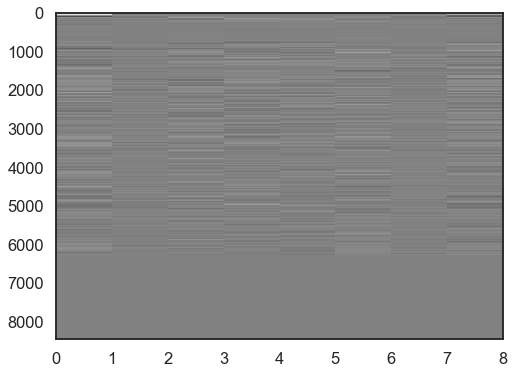

In [191]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack[:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [167]:
fk_ver, k_array_ver, f_array_ver = make_fk(data_stack, 0.8e-6, 8.625e-3)

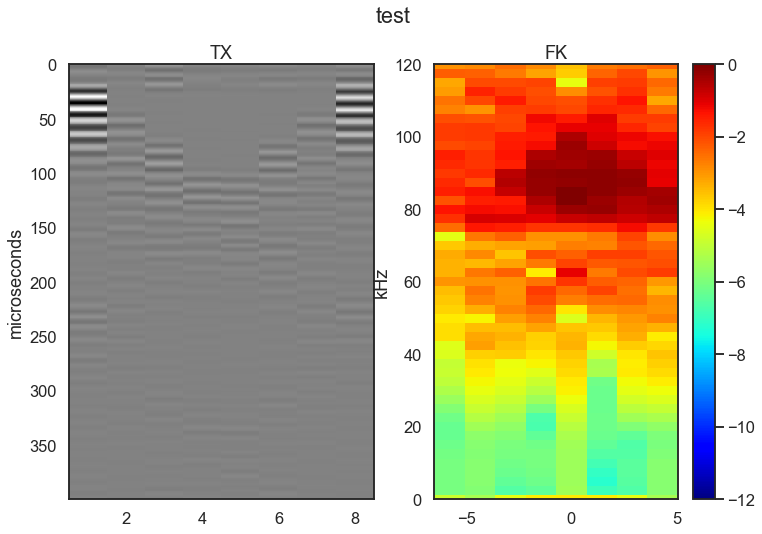

In [168]:
tx_fk_plot(data_stack[:500,:], 0.8e-6, 0.08625, 'test', maxfreq=120)

In [169]:
def remove_dc(data):
    return data - data.mean(axis=0, keepdims=True)

In [170]:
data_stack_dc_removed = remove_dc(data_stack)

In [171]:
def compute_rms(trace):
    squared = np.float64(np.square(trace))
    mean = np.sum(squared)/len(trace)
    rms = np.sqrt(mean)
    return rms

In [172]:
def compute_rms_values(data):
    rms_values = []
    trace_nums = np.arange(0, data.shape[1])
    for trace_num in trace_nums:
        rms_values.append(compute_rms(data[:,trace_num]))
    return rms_values

In [173]:
rms_values = compute_rms_values(data_stack_dc_removed[200:,:])

In [174]:
scaling_factors = [1/x for x in rms_values]

In [175]:
data_stack_scaled = np.zeros(shape=data_stack_dc_removed.shape)
for trace_num, scaling_factor in enumerate(scaling_factors):
    data_stack_scaled[:,trace_num] = scaling_factor*data_stack_dc_removed[:,trace_num]

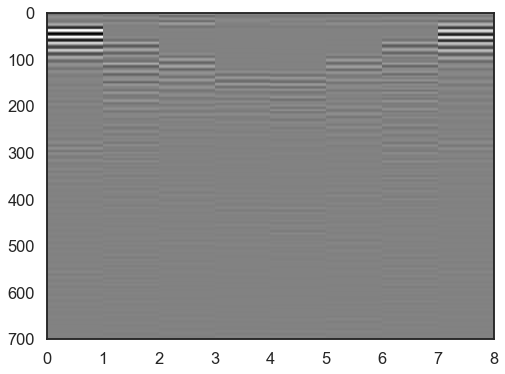

In [176]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled[0:700,:500], cmap='gray')
plt.gca().invert_yaxis()
plt.show()

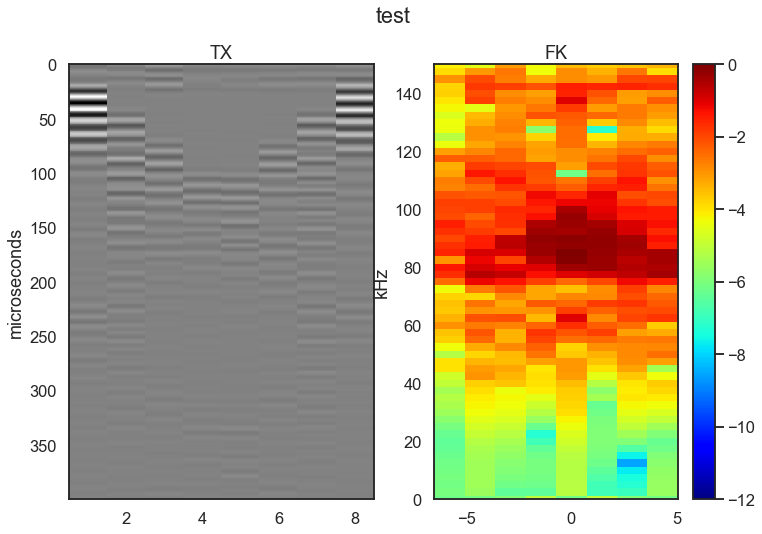

In [177]:
tx_fk_plot(data_stack_scaled[0:500,:], 0.8e-6, 0.08625, 'test', log=True, maxfreq=150)

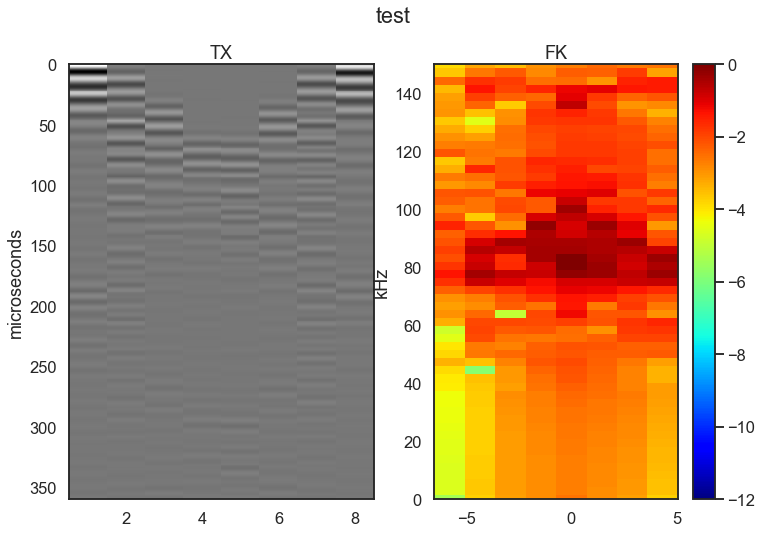

In [178]:
tx_fk_plot(data_stack_scaled[50:500,:], 0.8e-6, 0.08625, 'test', log=True, maxfreq=150)

In [192]:
data_stack_scaled.shape

(8448, 8)

In [194]:
# Resample
data_stack_scaled_resamp = scipy.signal.resample(data_stack_scaled[:600,:], 480)

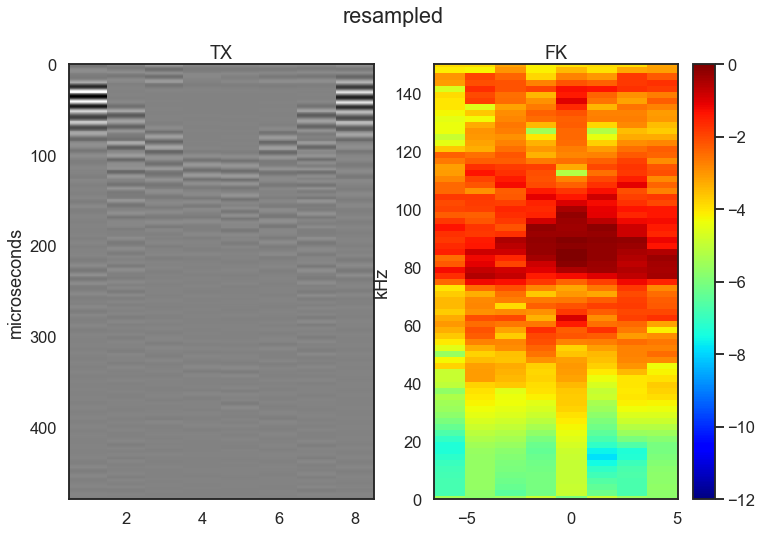

In [196]:
tx_fk_plot(data_stack_scaled_resamp, 1e-6, 0.08625, 'resampled', log=True, maxfreq=150)

## Picoscope data

realdatapath = '../data/input_real/Waveforms_clock_pos/'
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

first_iter = True
for freq in np.unique(df_waveforms.columns):
  measurement_temp = df_waveforms[freq].to_numpy()[817:4100:5,:-1]
  measurement_temp = measurement_temp/measurement_temp.max()
  if first_iter:
    measurements = np.expand_dims(measurement_temp, axis=0)
    first_iter = False
  else:
    measurements = np.concatenate((measurements, np.expand_dims(measurement_temp, axis=0)), axis=0)

measurements = measurements[:,:timesamples,:]
measurements.shape

In [189]:
measurements.shape

(41, 400, 11)

# Filtering
applyfilter = True
if applyfilter:
  for panelno in range(41):
    frq = panelno+40
    cutoff = frq*1.2*1000
    filtered_temp = butter_lowpass_filter(measurements[panelno], cutoff, 4)
    measurements[panelno] = filtered_temp/filtered_temp.max()

measurements.max()

tracebalancing = False
if tracebalancing:
  for panelno in range(41):
    tracemax = np.zeros(shape=measurements[panelno,1,:].shape)
    for traceno in range(len(tracemax)):
      tracemax[traceno] = measurements[panelno,:,traceno].max()
    measurements[panelno] = np.divide(measurements[panelno], tracemax)

add_noise_to_measurement = False # Set to False if added in FK instead
if add_noise_to_measurement:
  measurements = measurements + make_noise(noisedb, measurements.shape)


sns.set_style('white')
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[20,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[679,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

measurements_flat = measurements.reshape((len(measurements), np.prod(measurements.shape[1:])))
real_autoencoded = autoencoder_tx.predict(measurements_flat)

real_autoencoded.shape, measurements.shape

real_autoencoded_shaped = real_autoencoded.reshape(41, 11, timesamples)
real_autoencoded_shaped.shape

freq = 60
sns.set_style('white')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[freq-40,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.title(str(freq) + 'kHz; Measured')
plt.subplot(1,2,2)
plt.pcolormesh(real_autoencoded_shaped[freq-40,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Decoded')
plt.show()

In [ ]:
#stop

In [217]:
measurements.shape, measurements_flat.shape

((41, 400, 11), (1, 3840))

In [213]:
data_stack_scaled_resamp.shape

(1, 480, 8)

In [212]:
data_stack_scaled_resamp = np.expand_dims(data_stack_scaled_resamp, axis=0)

In [222]:
X_sample_n.shape

(3341, 1, 8, 400)

In [233]:
labels[(labels['Thickness'] == 6.8)]

modelname  Thickness  seed  Depression depth  \
42    model_s101_t034_d000_p000        6.8   101               0.0   
43    model_s101_t034_d000_p002        6.8   101               0.0   
44    model_s101_t034_d000_p004        6.8   101               0.0   
45    model_s101_t034_d000_p006        6.8   101               0.0   
46    model_s101_t034_d000_p008        6.8   101               0.0   
...                         ...        ...   ...               ...   
3210  model_s116_t034_d024_p002        6.8   116               4.8   
3211  model_s116_t034_d024_p004        6.8   116               4.8   
3212  model_s116_t034_d024_p006        6.8   116               4.8   
3213  model_s116_t034_d024_p008        6.8   116               4.8   
3214  model_s116_t034_d024_p010        6.8   116               4.8   

      Pitting depth  Depression location  Depression width  Thickness maximum  \
42              0.0           351.267366         55.653407                6.8   
43              0.4           351.267366         55.653407                6.8   
44              0.8           351.267366         55.653407                6.8   
45              1.2           351.267366         55.653407                6.8   
46              1.6           351.267366         55.653407                6.8   
...             ...                  ...               ...                ...   
3210            0.4           302.458280         37.896593                6.8   
3211            0.8           302.458280         37.896593                6.8   
3212            1.2           302.458280         37.896593                6.8   
3213            1.6           302.458280         37.896593                6.8   
3214            2.0           302.458280         37.896593                6.8   

      Thickness minimum  Thickness mean  Thickness median  Thickness std  \
42                  6.8        6.800000               6.8       0.000000   
43                  6.4        6.603877               6.6       0.145226   
44                  6.0        6.469792               6.4       0.234485   
45                  5.6        6.414352               6.4       0.289402   
46                  5.2        6.399595               6.4       0.310864   
...                 ...             ...               ...            ...   
3210                1.6        5.943345               6.6       1.359942   
3211                1.2        5.813947               6.4       1.368364   
3212                1.0        5.745023               6.2       1.380354   
3213                1.0        5.713773               6.2       1.388619   
3214                1.0        5.700463               6.2       1.392666   

      thickness_var  model_rough_coeff  num_pits  
42         0.000000           1.000000         0  
43         0.021091           1.271427         0  
44         0.054983           1.314587       228  
45         0.083753           1.322979        85  
46         0.096637           1.324897        19  
...             ...                ...       ...  
3210       1.849443           1.274064         0  
3211       1.872419           1.312067       178  
3212       1.905376           1.324056        88  
3213       1.928262           1.324535        33  
3214       1.939519           1.325015        15  

[671 rows x 15 columns]

In [238]:
X_sample_n.shape

(3341, 1, 8, 400)

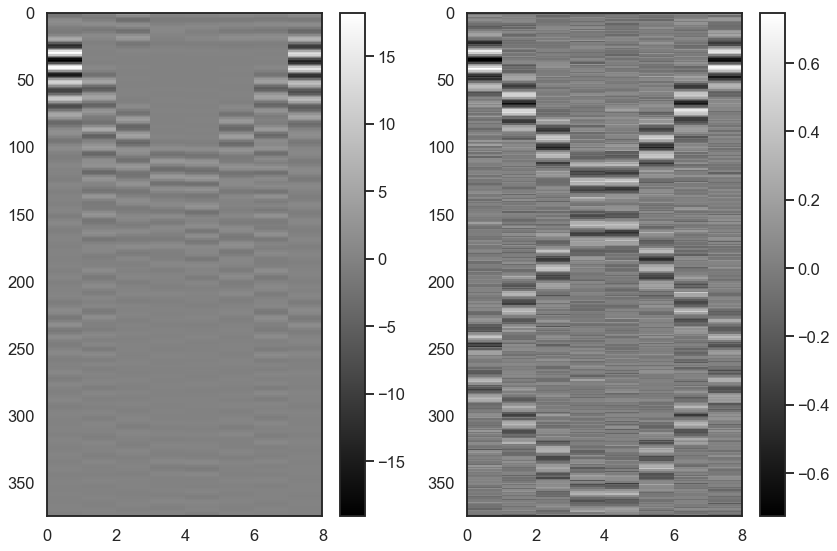

In [240]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp[0,:400-25,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n[42,0,:,25:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.tight_layout()

In [215]:
measurements_flat = data_stack_scaled_resamp.reshape((len(data_stack_scaled_resamp), np.prod(data_stack_scaled_resamp.shape[1:])))

In [216]:
real_encoded = encoder_tx.predict(measurements_flat)

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/dense/BiasAdd' defined at (most recent call last):
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\traitlets\config\application.py", line 972, in launch_instance
      app.start()
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\Magnus\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Magnus\AppData\Local\Temp\ipykernel_26632\2013239197.py", line 1, in <cell line: 1>
      real_encoded = encoder_tx.predict(measurements_flat)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\venv\lib\site-packages\keras\layers\core\dense.py", line 232, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model_1/dense/BiasAdd'
Matrix size-incompatible: In[0]: [1,3840], In[1]: [3200,512]
	 [[{{node model_1/dense/BiasAdd}}]] [Op:__inference_predict_function_333615]

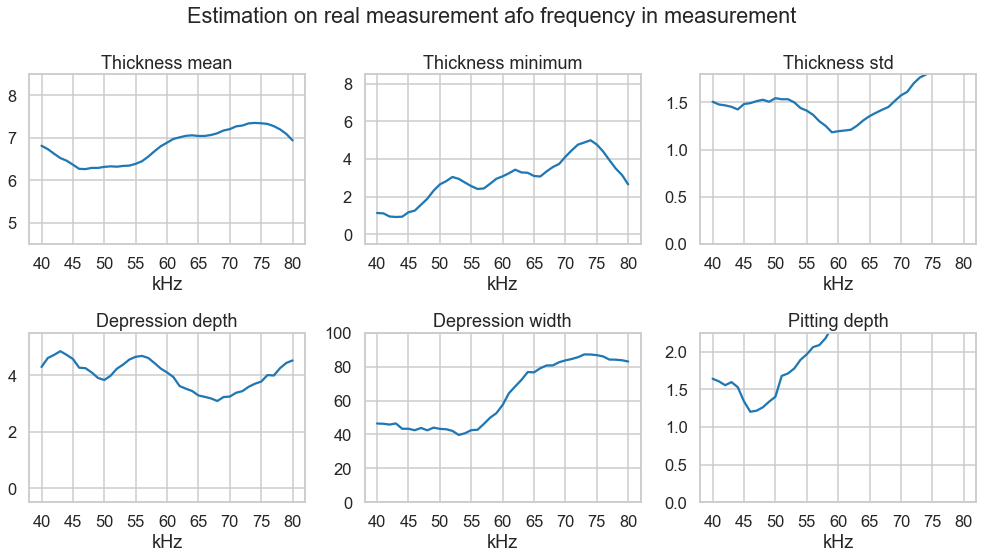

In [ ]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = autoencoder_regression_models_tx[attribute](real_encoded)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement afo frequency in measurement')
plt.tight_layout()
plt.show()

# FK

In [ ]:
def make_fk_samples(X, dt, dx, fk_minfreq=20e3, fk_maxfreq=120e3, returncomplex=False, returndb=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)#/np.max(np.abs(fk_temp))
        if returndb:
          fk_temp_amp = 20*np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= fk_minfreq) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [ ]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n, dt, dx, returndb=False)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c, dt, dx, returndb=False)

(3341, 1, 2, 400, 11)
(3341, 1, 2, 400, 11)


In [ ]:
X_sample_n_fk.shape

(3341, 1, 2, 41, 11)

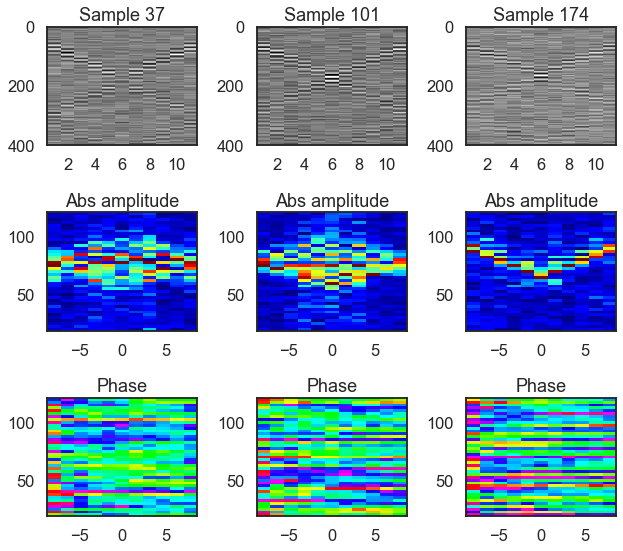

In [ ]:
cases = [37, 101, 174]
clock_array = np.array([2, 4, 6, 8, 10])
sns.set_style("white")
sns.set_context("talk")
plt.figure(figsize=(3*len(cases),8))
for i, case in enumerate(cases):
  plt.subplot(3, len(cases), i+1)
  #plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet')
  plt.pcolormesh(X_sample_n[case,0,:,:].T, cmap='gray')
  plt.gca().invert_yaxis()
  plt.xticks(ticks=clock_array-0.5, labels=clock_array)
  #plt.title('Sample ' + str(case) + '; Thickness min: ' + str(np.round(labels.iloc[case]['Thickness minimum']*0.2, decimals=1)))

  plt.title('Sample ' + str(case))
  plt.subplot(3, len(cases), i+len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,0,:,:], cmap='jet')
  plt.title('Abs amplitude')
  #plt.colorbar()
  plt.subplot(3, len(cases), i+2*len(cases)+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case,0,1,:,:], cmap='hsv')
  plt.title('Phase')
  #plt.colorbar()
  #plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [ ]:
def make_fk_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.random(size=noiseshape)*noiselev
  return noise

In [ ]:
X_sample_c_n_fk = X_sample_c_fk + make_fk_noise(noisedb, X_sample_c_fk.shape)

In [ ]:
labels.iloc[230]

modelname              model_s102_t032_d012_p004
Thickness                                    6.4
seed                                         102
Depression depth                             2.4
Pitting depth                                0.8
Depression location                   379.358756
Depression width                       64.078952
Thickness maximum                            6.4
Thickness minimum                            3.2
Thickness mean                          5.528183
Thickness median                             5.8
Thickness std                           0.836652
thickness_var                           0.699987
model_rough_coeff                       1.310149
num_pits                                     180
Name: 230, dtype: object

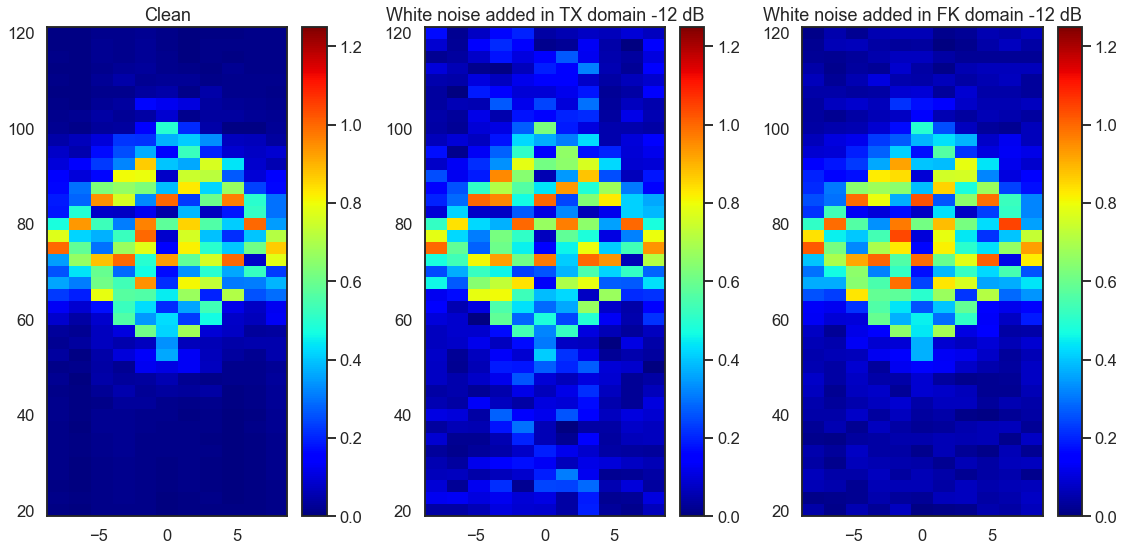

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title('Clean')
plt.subplot(1,3,2)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in TX domain {noisedb} dB')
plt.subplot(1,3,3)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in FK domain {noisedb} dB')
plt.tight_layout()
plt.show()

In [ ]:
X_sample_n_fk = X_sample_c_n_fk

In [ ]:
X_sample_n_fk.shape, X_sample_n_fk.max(), X_sample_c_fk.shape

((3341, 1, 41, 11), 1.0630896705642758, (3341, 1, 41, 11))

In [ ]:
if data_augmentation:
  X_sample_c_autoencode_fk, x_array, f_array = make_fk_samples(X_sample_c_autoencode, dt, dx, returndb=False)
  X_sample_n_autoencode_fk, x_array, f_array = make_fk_samples(X_sample_n_autoencode, dt, dx, returndb=False)
  X_sample_c_autoencode_fk.shape, X_sample_n_autoencode_fk.shape
  if amp_only:
    X_sample_c_autoencode_fk = X_sample_c_autoencode_fk[:,:,0,:,:]
    X_sample_n_autoencode_fk = X_sample_n_autoencode_fk[:,:,0,:,:]
  x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_autoencode_fk, X_sample_c_autoencode_fk, test_size=0.2, random_state=42)
else:
  x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [ ]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [ ]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((2672, 451), (669, 451), (2672, 451), (669, 451))

# Direct Regression in FK

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


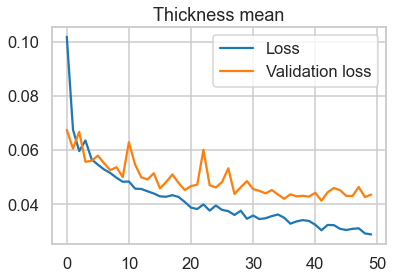

21/21 [==============================] - 0s 3ms/step - loss: 0.0436
loss: 0.04355433210730553
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


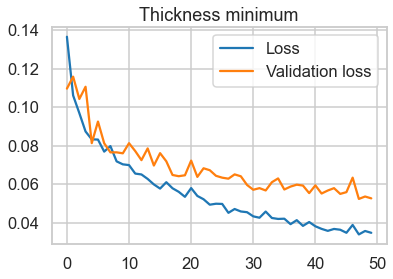

21/21 [==============================] - 0s 2ms/step - loss: 0.0526
loss: 0.0525512769818306
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


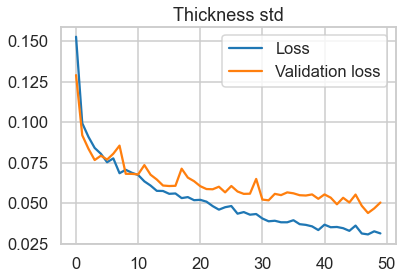

21/21 [==============================] - 0s 2ms/step - loss: 0.0503
loss: 0.05032778158783913
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


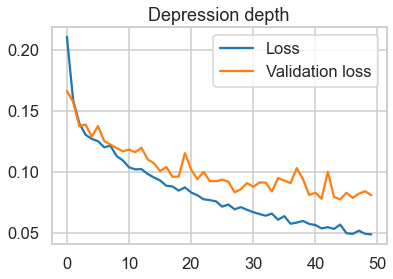

21/21 [==============================] - 0s 2ms/step - loss: 0.0808
loss: 0.08078022301197052
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


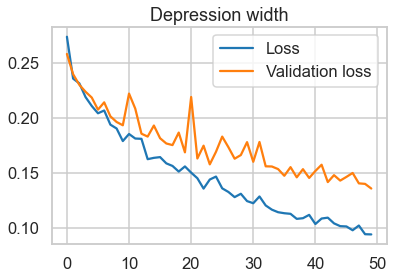

21/21 [==============================] - 0s 2ms/step - loss: 0.1357
loss: 0.13569152355194092
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


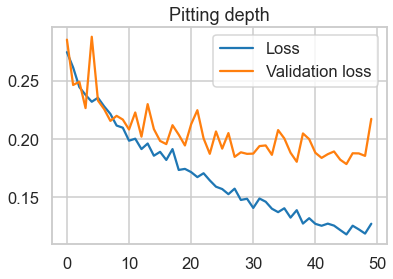

21/21 [==============================] - 0s 2ms/step - loss: 0.2175
loss: 0.21747535467147827


In [ ]:
df_loss, df_test, df_predict, direct_regression_models_fk, min_max_scalers = do_regression(X_sample_n_fk, label_sample, attributes)

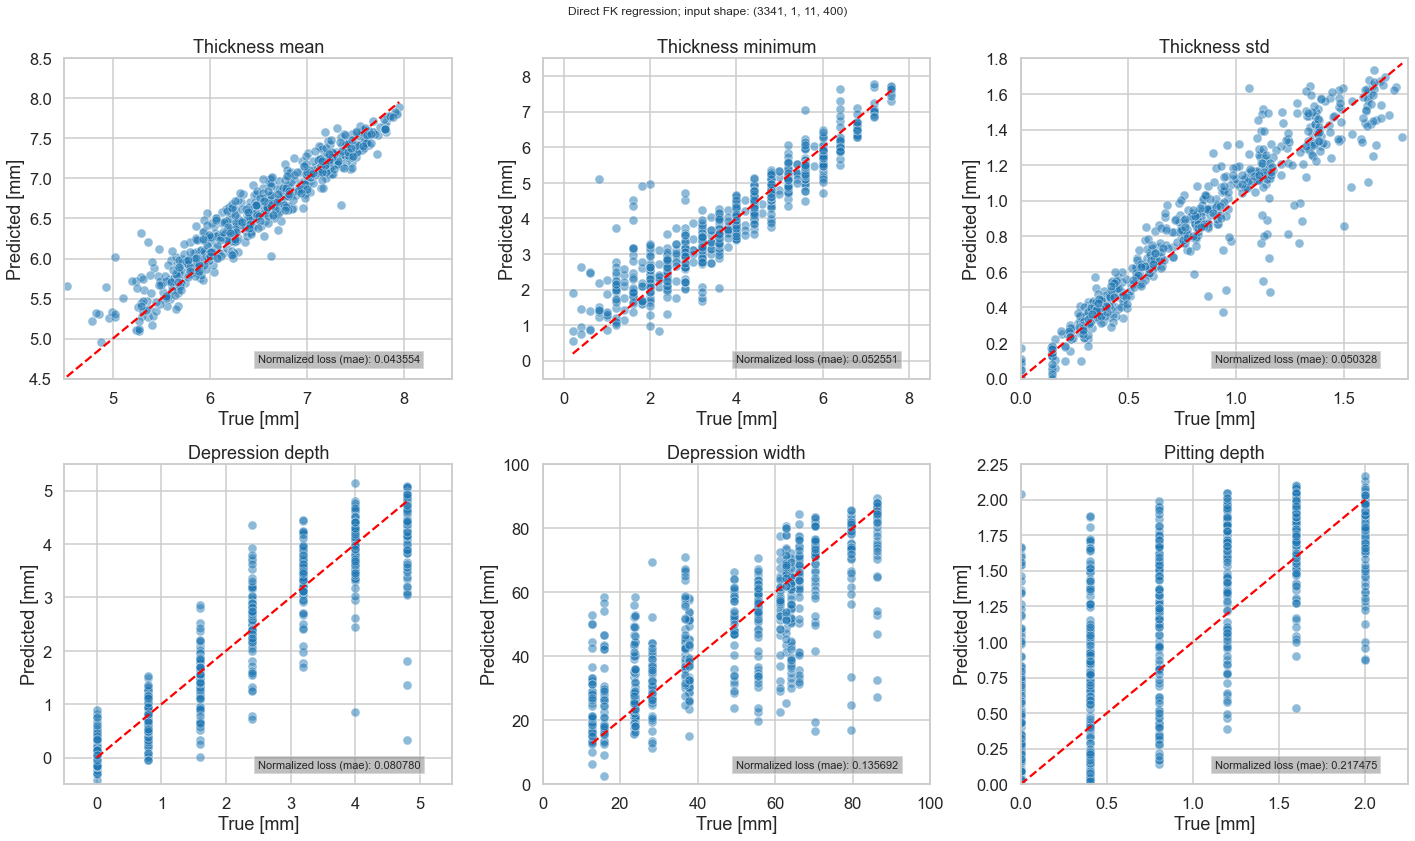

In [ ]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct FK regression; input shape: '+ str(X_sample_n.shape))

In [ ]:
measurements_mod = measurements.swapaxes(1,2)


In [ ]:
measurements_mod = np.expand_dims(measurements_mod, 1)

In [ ]:
measurements_mod.shape, X_sample_n.shape

((41, 1, 11, 400), (3341, 1, 11, 400))

In [ ]:
measurements_fk, x_array, f_array = make_fk_samples(measurements_mod, dt, dx, returndb=False)

(41, 1, 2, 400, 11)


In [ ]:
if amp_only:
  measurements_fk = measurements_fk[:,:,0,:,:]

In [ ]:
add_noise_to_fk_measurement = True
if add_noise_to_fk_measurement:
  measurements_fk = measurements_fk + make_fk_noise(noisedb, measurements_fk.shape)

In [ ]:
measurements_flat_fk = measurements_fk.reshape((len(measurements_fk), np.prod(measurements_fk.shape[1:])))

In [ ]:
measurements_flat_fk.shape

(41, 451)

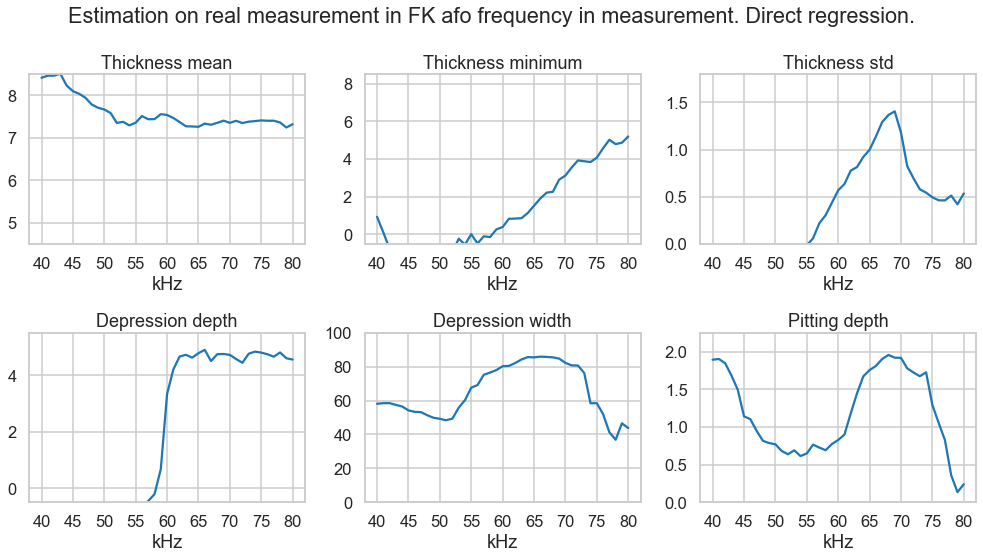

In [ ]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = direct_regression_models_fk[attribute](measurements_flat_fk)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement in FK afo frequency in measurement. Direct regression.')
plt.tight_layout()
plt.show()

# Autoencoder in FK

Epoch 1/100
11/11 [==============================] - 1s 20ms/step - loss: 0.0727 - val_loss: 0.0611
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0470 - val_loss: 0.0313
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0255 - val_loss: 0.0213
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0200 - val_loss: 0.0192
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0185 - val_loss: 0.0180
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 11

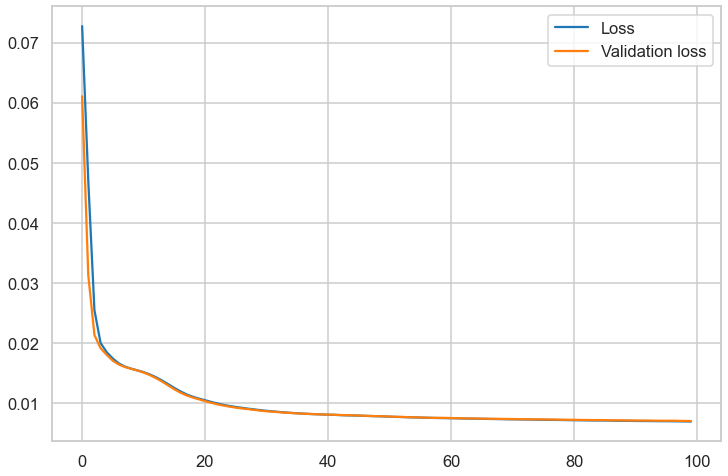

In [ ]:
autoencoder_fk, encoder_fk = make_autoencoder(input_dim=x_train_flat_fk.shape[1], encoding_dim=16, activation='relu') #was 24
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [ ]:
int(np.floor(np.log(x_train_flat_fk.shape[1]/32)/np.log(2)))

3

In [ ]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

21/21 [==============================] - 0s 2ms/step


In [ ]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [ ]:
decoded_shaped_fk.shape, x_test_fk.shape

((669, 1, 41, 11), (669, 1, 41, 11))

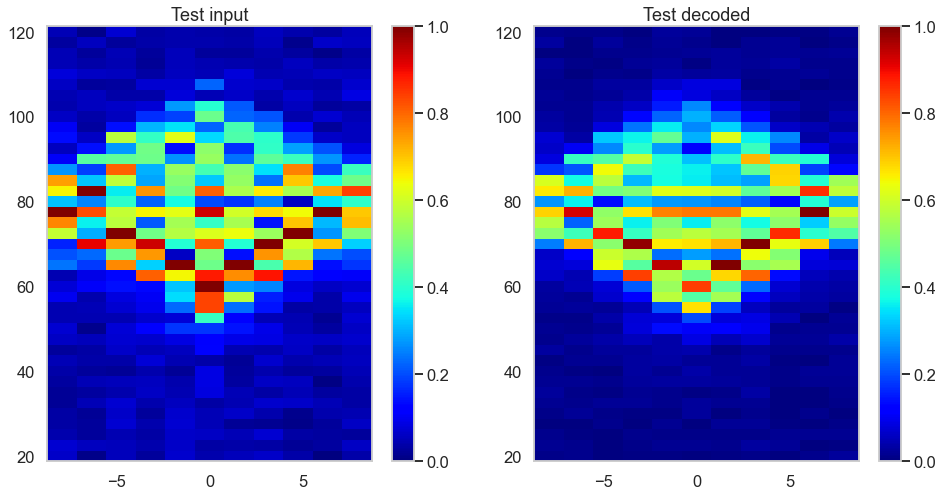

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

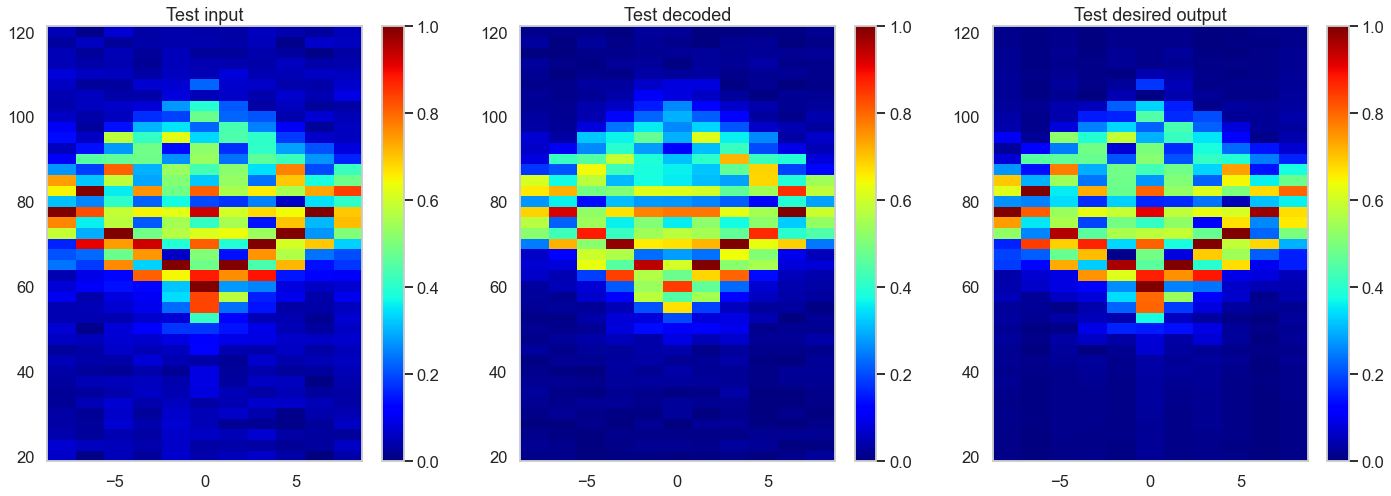

In [ ]:
#sampleno = 3
for sampleno in range(0,1):
  plt.figure(figsize=(24,8))

  plt.subplot(1, 3, 1)
  plt.pcolormesh(x_array, f_array/1e3, x_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test input')

  plt.subplot(1, 3, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test decoded')

  plt.subplot(1, 3, 3)
  plt.pcolormesh(x_array, f_array/1e3, y_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test desired output')


  #plt.savefig('./images/simulations_autoencoder_' + str(sampleno).zfill(2) + '.png')
  plt.show()

In [ ]:
decoded_measurements_fk = autoencoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 16ms/step


In [ ]:
encoded_measurements_fk = encoder_fk.predict(measurements_flat_fk)

2/2 [==============================] - 0s 0s/step


In [ ]:
decoded_measurements_shaped_fk = decoded_measurements_fk.reshape(len(decoded_measurements_fk), measurements_fk.shape[1], measurements_fk.shape[2], measurements_fk.shape[3])

In [ ]:
decoded_measurements_shaped_fk.shape

(41, 1, 41, 11)

In [ ]:
for testno in range(20,20):
  plt.figure(figsize=(16,8))

  plt.subplot(1, 2, 1)
  plt.pcolormesh(x_array, f_array/1e3, measurements_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement input: '+ str(testno+40) + 'kHz')

  plt.subplot(1, 2, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[testno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Measurement decoded')

  #plt.subplot(1, 3, 3)
  #plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[20, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  #plt.colorbar()
  #plt.title('Test desired output')

  #plt.savefig('./images/measurements_encoded_' +str(testno).zfill(2) + '.png')
  plt.show()

In [ ]:
X_sample_flat_fk = X_sample_n_fk.reshape((len(X_sample_n_fk), np.prod(X_sample_n_fk.shape[1:])))
X_sample_flat_fk.shape

(3341, 451)

In [ ]:
encoded_all_fk = encoder_fk.predict(X_sample_flat_fk)

 27/105 [======>.......................] - ETA: 0s

105/105 [==============================] - 0s 2ms/step


Thickness mean
Layer added; size: 4
Layer added; size: 2


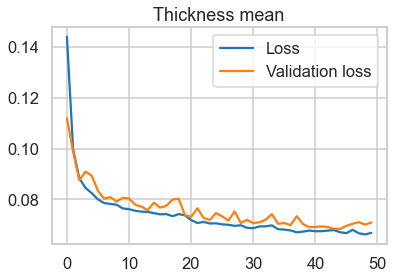

21/21 [==============================] - 0s 2ms/step - loss: 0.0709
loss: 0.07088111340999603
Thickness minimum
Layer added; size: 4
Layer added; size: 2


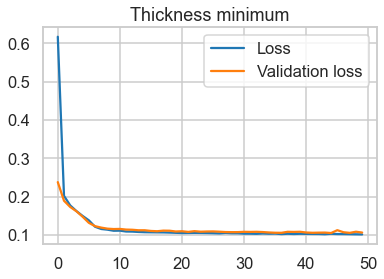

21/21 [==============================] - 0s 1ms/step - loss: 0.1063
loss: 0.10631947964429855
Thickness std
Layer added; size: 4
Layer added; size: 2


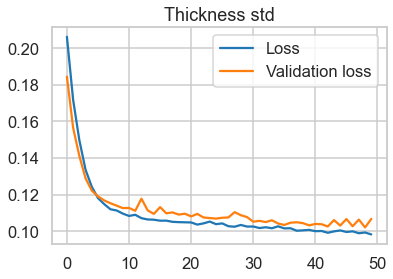

21/21 [==============================] - 0s 2ms/step - loss: 0.1067
loss: 0.10671769082546234
Depression depth
Layer added; size: 4
Layer added; size: 2


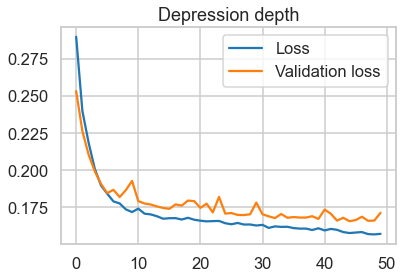

21/21 [==============================] - 0s 2ms/step - loss: 0.1714
loss: 0.17142269015312195
Depression width
Layer added; size: 4
Layer added; size: 2


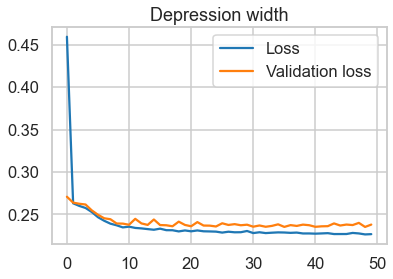

21/21 [==============================] - 0s 2ms/step - loss: 0.2380
loss: 0.23800310492515564
Pitting depth
Layer added; size: 4
Layer added; size: 2


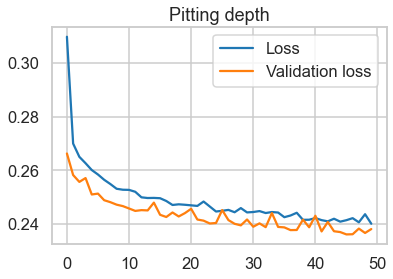

21/21 [==============================] - 0s 2ms/step - loss: 0.2381
loss: 0.23813451826572418


In [ ]:
df_loss, df_test, df_predict, autoencoder_regression_models_fk, min_max_scalers = do_regression(encoded_all_fk, label_sample, attributes)

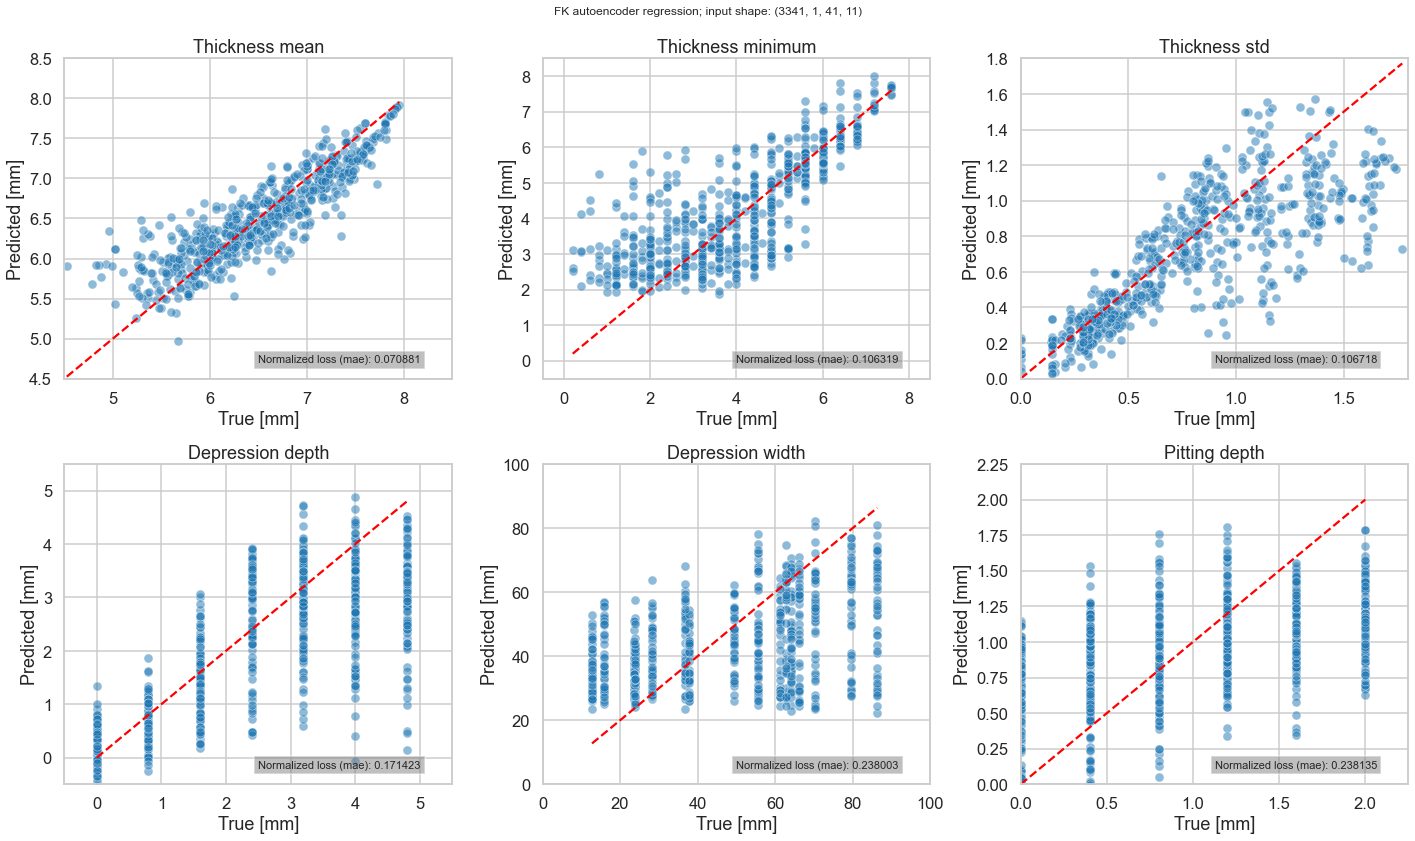

In [ ]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='FK autoencoder regression; input shape: '+ str(X_sample_n_fk.shape))

In [ ]:
df_test.columns

Index(['Thickness mean', 'Thickness minimum', 'Thickness std',
       'Depression depth', 'Depression width', 'Pitting depth'],
      dtype='object')

In [ ]:
df_scales['Thickness mean'][0]

4.5

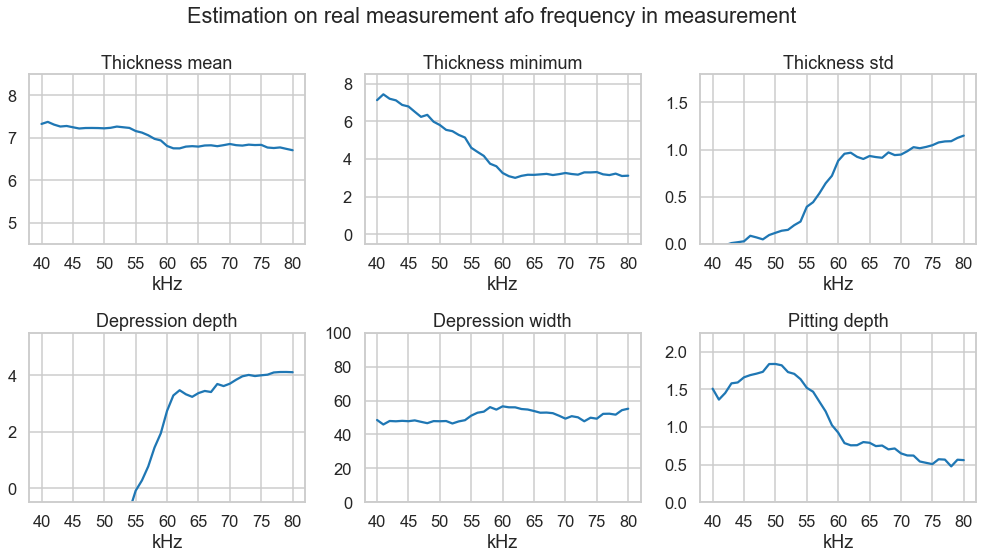

In [ ]:
sns.set_context('talk')
sns.set_style('whitegrid')
real_prediction = {}
plt.figure(figsize=(14, 8))
for i, attribute in enumerate(attributes):
  real_prediction_norm = autoencoder_regression_models_fk[attribute](encoded_measurements_fk)

  real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.subplot(2,3, i+1)
  plt.plot(real_prediction[attribute])
  plt.ylim([df_scales[attribute][0], df_scales[attribute][1]])
  plt.title(attribute)
  plt.xticks(range(0, 41, 5), range(40, 81, 5))
  plt.xlabel('kHz')
plt.suptitle('Estimation on real measurement afo frequency in measurement')
plt.tight_layout()
plt.show()

In [ ]:
cases_ideal

[0,
 42,
 84,
 126,
 168,
 210,
 250,
 292,
 334,
 376,
 418,
 458,
 500,
 542,
 584,
 626,
 666,
 708,
 750,
 792,
 834,
 876,
 918,
 960,
 1002,
 1044,
 1085,
 1127,
 1169,
 1211,
 1253,
 1295,
 1337,
 1379,
 1421,
 1463,
 1503,
 1545,
 1587,
 1629,
 1671,
 1711,
 1753,
 1795,
 1837,
 1879,
 1919,
 1961,
 2003,
 2045,
 2087,
 2129,
 2171,
 2213,
 2255,
 2297,
 2337,
 2379,
 2421,
 2463,
 2505,
 2547,
 2589,
 2631,
 2673,
 2715,
 2755,
 2797,
 2839,
 2881,
 2923,
 2964,
 3005,
 3047,
 3089,
 3131,
 3173,
 3215,
 3257,
 3299]

In [ ]:
def decode_sample(autoencoder, sample):
  sample_flat = sample.reshape(np.prod(sample.shape))
  sample_flat = np.expand_dims(sample_flat, axis=0)
  decoded_sample = autoencoder.predict(sample_flat)
  decoded_sample_shaped = decoded_sample.reshape(sample.shape)
  return decoded_sample_shaped



In [ ]:
cases_ideal

[0,
 42,
 84,
 126,
 168,
 210,
 250,
 292,
 334,
 376,
 418,
 458,
 500,
 542,
 584,
 626,
 666,
 708,
 750,
 792,
 834,
 876,
 918,
 960,
 1002,
 1044,
 1085,
 1127,
 1169,
 1211,
 1253,
 1295,
 1337,
 1379,
 1421,
 1463,
 1503,
 1545,
 1587,
 1629,
 1671,
 1711,
 1753,
 1795,
 1837,
 1879,
 1919,
 1961,
 2003,
 2045,
 2087,
 2129,
 2171,
 2213,
 2255,
 2297,
 2337,
 2379,
 2421,
 2463,
 2505,
 2547,
 2589,
 2631,
 2673,
 2715,
 2755,
 2797,
 2839,
 2881,
 2923,
 2964,
 3005,
 3047,
 3089,
 3131,
 3173,
 3215,
 3257,
 3299]

In [ ]:
'''
# Warning: These are not test-sets, but training sets.
plt.figure(figsize=(20,14))
for i, case in enumerate(cases_ideal):
  plt.subplot(3, len(cases_ideal), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.title('Thickness: ' + str(labels.iloc[case]['Thickness mean']) + ' mm')
  plt.subplot(3, len(cases_ideal), len(cases_ideal)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[case,0,:,:]), cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.subplot(3, len(cases_ideal), 2*len(cases_ideal)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
plt.suptitle('Synthetic FK of ideal cases (Top: Noisy; Middle: Decoded; Bottom: Desired output)')
plt.tight_layout()
plt.show()
'''

"\n# Warning: These are not test-sets, but training sets.\nplt.figure(figsize=(20,14))\nfor i, case in enumerate(cases_ideal):\n  plt.subplot(3, len(cases_ideal), i+1)\n  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)\n  plt.xticks([])\n  if i>0:\n    plt.yticks([])\n  plt.title('Thickness: ' + str(labels.iloc[case]['Thickness mean']) + ' mm')\n  plt.subplot(3, len(cases_ideal), len(cases_ideal)+i+1)\n  plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[case,0,:,:]), cmap='jet', vmin=0, vmax=1)\n  plt.xticks([])\n  if i>0:\n    plt.yticks([])\n  plt.subplot(3, len(cases_ideal), 2*len(cases_ideal)+i+1)\n  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet', vmin=0, vmax=1)\n  plt.xticks([])\n  if i>0:\n    plt.yticks([])\nplt.suptitle('Synthetic FK of ideal cases (Top: Noisy; Middle: Decoded; Bottom: Desired output)')\nplt.tight_layout()\nplt.show()\n"

In [ ]:
labels.iloc[case]['Thickness mean']

7.84126157407407

In [ ]:
X_sample_n_fk.shape

(3341, 1, 41, 11)

In [ ]:
real_prediction['Thickness mean'][20].item()

6.807287124020081

In [ ]:
freqno = 20
limit = 0.5
labels[(labels['Thickness mean'] >= real_prediction['Thickness mean'][freqno].item() - limit  ) & (labels['Thickness mean'] <= real_prediction['Thickness mean'][freqno].item() + limit) &
       (labels['Thickness minimum'] >= real_prediction['Thickness minimum'][freqno].item() - limit) & (labels['Thickness minimum'] <= real_prediction['Thickness minimum'][freqno].item() +limit) &
       (labels['Depression depth'] >= real_prediction['Depression depth'][freqno].item() - limit) & (labels['Depression depth'] <= real_prediction['Depression depth'][freqno].item() + limit) &
       (labels['Pitting depth'] >= real_prediction['Pitting depth'][freqno].item() - limit) & (labels['Pitting depth'] <= real_prediction['Pitting depth'][freqno].item() + limit)]

modelname  Thickness  seed  Depression depth  \
105   model_s101_t036_d012_p006        7.2   101               2.4   
152   model_s101_t038_d016_p004        7.6   101               3.2   
153   model_s101_t038_d016_p006        7.6   101               3.2   
360   model_s102_t038_d016_p004        7.6   102               3.2   
361   model_s102_t038_d016_p006        7.6   102               3.2   
403   model_s102_t040_d016_p006        8.0   102               3.2   
526   model_s103_t036_d016_p004        7.2   103               3.2   
527   model_s103_t036_d016_p006        7.2   103               3.2   
568   model_s103_t038_d016_p004        7.6   103               3.2   
569   model_s103_t038_d016_p006        7.6   103               3.2   
729   model_s104_t036_d012_p006        7.2   104               2.4   
734   model_s104_t036_d016_p004        7.2   104               3.2   
735   model_s104_t036_d016_p006        7.2   104               3.2   
776   model_s104_t038_d016_p004        7.6   104               3.2   
777   model_s104_t038_d016_p006        7.6   104               3.2   
939   model_s105_t036_d012_p006        7.2   105               2.4   
944   model_s105_t036_d016_p004        7.2   105               3.2   
945   model_s105_t036_d016_p006        7.2   105               3.2   
986   model_s105_t038_d016_p004        7.6   105               3.2   
987   model_s105_t038_d016_p006        7.6   105               3.2   
1238  model_s106_t040_d016_p006        8.0   106               3.2   
1405  model_s107_t038_d016_p004        7.6   107               3.2   
1406  model_s107_t038_d016_p006        7.6   107               3.2   
1448  model_s107_t040_d016_p006        8.0   107               3.2   
1523  model_s108_t034_d012_p004        6.8   108               2.4   
1524  model_s108_t034_d012_p006        6.8   108               2.4   
1529  model_s108_t034_d016_p004        6.8   108               3.2   
1571  model_s108_t036_d016_p004        7.2   108               3.2   
1572  model_s108_t036_d016_p006        7.2   108               3.2   
1613  model_s108_t038_d016_p004        7.6   108               3.2   
1614  model_s108_t038_d016_p006        7.6   108               3.2   
1774  model_s109_t036_d012_p006        7.2   109               2.4   
1821  model_s109_t038_d016_p004        7.6   109               3.2   
1822  model_s109_t038_d016_p006        7.6   109               3.2   
1864  model_s109_t040_d016_p006        8.0   109               3.2   
2029  model_s110_t038_d016_p004        7.6   110               3.2   
2030  model_s110_t038_d016_p006        7.6   110               3.2   
2072  model_s110_t040_d016_p006        8.0   110               3.2   
2192  model_s111_t036_d012_p006        7.2   111               2.4   
2197  model_s111_t036_d016_p004        7.2   111               3.2   
2198  model_s111_t036_d016_p006        7.2   111               3.2   
2239  model_s111_t038_d016_p004        7.6   111               3.2   
2240  model_s111_t038_d016_p006        7.6   111               3.2   
2447  model_s112_t038_d016_p004        7.6   112               3.2   
2448  model_s112_t038_d016_p006        7.6   112               3.2   
2490  model_s112_t040_d016_p006        8.0   112               3.2   
2567  model_s113_t034_d012_p004        6.8   113               2.4   
2615  model_s113_t036_d016_p004        7.2   113               3.2   
2616  model_s113_t036_d016_p006        7.2   113               3.2   
2657  model_s113_t038_d016_p004        7.6   113               3.2   
2658  model_s113_t038_d016_p006        7.6   113               3.2   
2865  model_s114_t038_d016_p004        7.6   114               3.2   
3073  model_s115_t038_d016_p004        7.6   115               3.2   
3074  model_s115_t038_d016_p006        7.6   115               3.2   
3116  model_s115_t040_d016_p006        8.0   115               3.2   
3241  model_s116_t036_d016_p004        7.2   116               3.2   
3242  model_s116_t036_d016_p006 

In [ ]:
measurements_fk.shape

(41, 1, 41, 11)

1/1 [==============================] - 0s 47ms/step


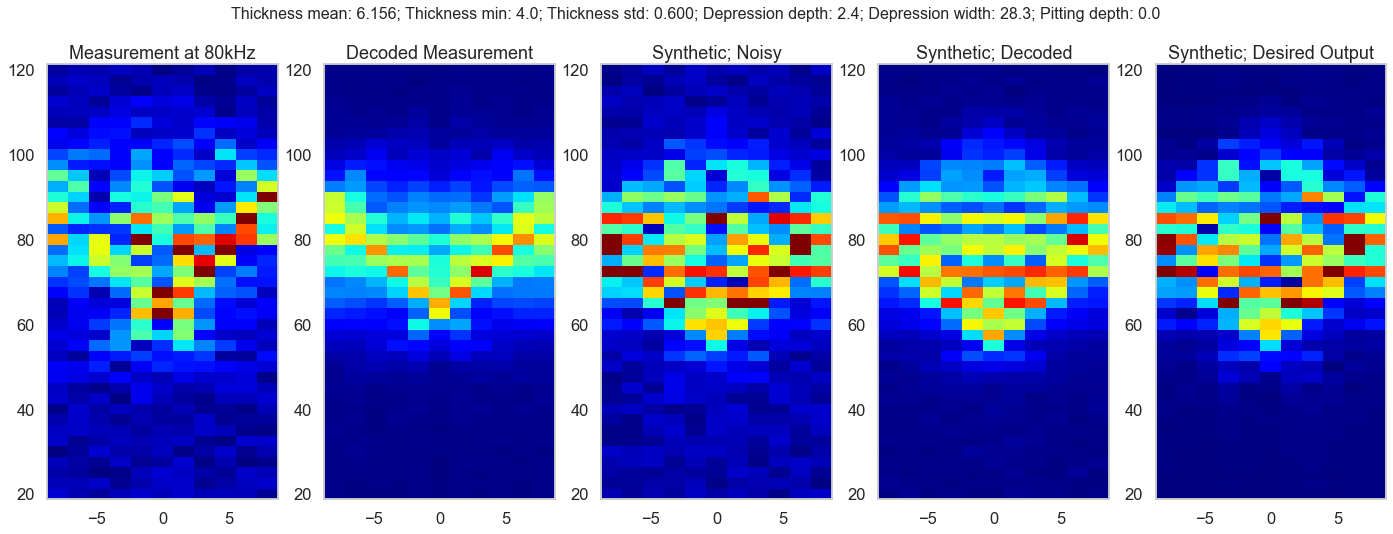

In [ ]:
synthsample = 1095
synthsample = 644

titlestring = f"Thickness mean: {labels.iloc[synthsample]['Thickness mean']:.3f}; " \
              f"Thickness min: {labels.iloc[synthsample]['Thickness minimum']:.1f}; " \
              f"Thickness std: {labels.iloc[synthsample]['Thickness std']:.3f}; " \
              f"Depression depth: {labels.iloc[synthsample]['Depression depth']:.1f}; " \
              f"Depression width: {labels.iloc[synthsample]['Depression width']:.1f}; " \
              f"Pitting depth: {labels.iloc[synthsample]['Pitting depth']:.1f}"

plt.figure(figsize=(24,8))
plt.subplot(1,5,1)
plt.pcolormesh(x_array, f_array/1e3, measurements_fk[40, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Measurement at ' + str(40+40) + 'kHz')
plt.subplot(1,5,2)
plt.pcolormesh(x_array, f_array/1e3, decoded_measurements_shaped_fk[40, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Decoded Measurement')
plt.subplot(1,5,3)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[synthsample, 0,:, :], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Noisy')
plt.subplot(1,5,4)
plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[synthsample,0,:,:]), cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Decoded')
plt.subplot(1,5,5)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[synthsample, 0,:,:], cmap='jet', vmin=0, vmax=1)
plt.title('Synthetic; Desired Output')
plt.suptitle(titlestring, fontsize=16)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Check how FK looks for increasing thickness std
tolerance = 0.01
cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Thickness std').index.tolist()
#cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Pitting depth').index.tolist()
#cases_increasing_std = labels[(labels['Thickness mean'] > 6.8-tolerance) & (labels['Thickness mean'] < 6.8 + tolerance)].sort_values(by='Depression depth').index.tolist()

1/1 [==============================] - 0s 27ms/step


C:\Users\Magnus\AppData\Local\Temp\ipykernel_25200\1116639088.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


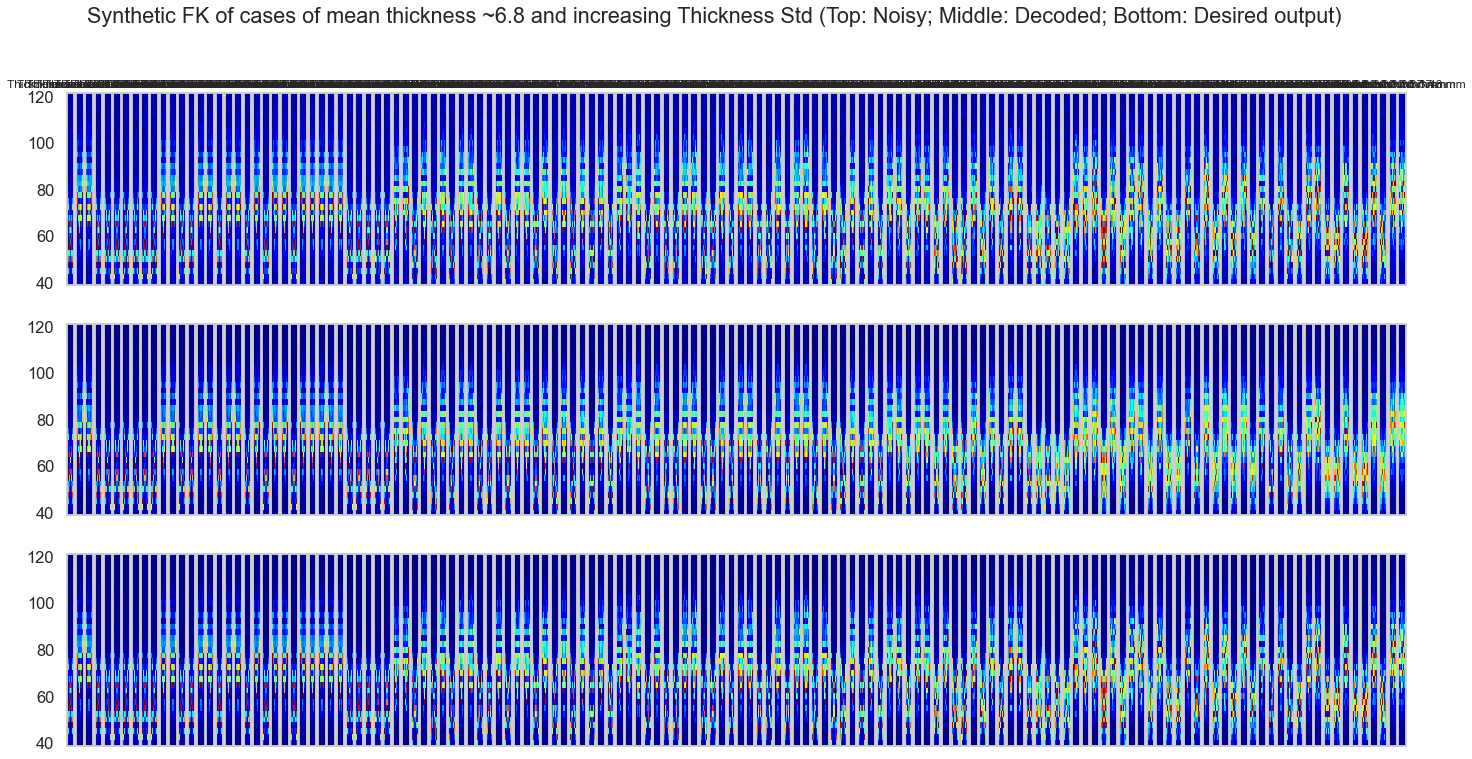

In [ ]:
plt.figure(figsize=(24, 12))
for i, case in enumerate(cases_increasing_std):

  plt.subplot(3, len(cases_increasing_std), i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[case, 0,:, :], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.title(f"Thickness std: {(labels.iloc[case]['Thickness std']):.2f} mm", fontsize=12)
  plt.subplot(3, len(cases_increasing_std), len(cases_increasing_std)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, decode_sample(autoencoder_fk, X_sample_n_fk[case,0,:,:]), cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
  plt.subplot(3, len(cases_increasing_std), 2*len(cases_increasing_std)+i+1)
  plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[case,0,:,:], cmap='jet', vmin=0, vmax=1)
  plt.xticks([])
  if i>0:
    plt.yticks([])
plt.suptitle('Synthetic FK of cases of mean thickness ~6.8 and increasing Thickness Std (Top: Noisy; Middle: Decoded; Bottom: Desired output)')
plt.tight_layout()

plt.show()

In [ ]:
encoder_fk.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 363)]             0         
                                                                 
 dense_112 (Dense)           (None, 64)                23296     
                                                                 
 dense_113 (Dense)           (None, 32)                2080      
                                                                 
 dense_114 (Dense)           (None, 16)                528       
                                                                 
Total params: 25,904
Trainable params: 25,904
Non-trainable params: 0
_________________________________________________________________
